# Twitter Sentiment Analysis - PiS vs PO

In this project we will analyze sentiment on two most popular political parties from Poland based on tweets concerning Prawo i Sprawiedliwość and Platforma Obywatelska.

At the beginning we will prepare the dataset by downloading tweets from previous 12 months and preprocess them to get rid of unnecessary characters and emojis.

In [ ]:
# Installing necessary packages
!pip3 install git+https://github.com/JustAnotherArchivist/snscrape.git
!pip3 install unidecode
!pip3 install pystempel
!pip3 install nltk transformers
!pip install text2emotion
!pip install emoji==1.6.3
!pip install -U deep-translator

In [ ]:
# Downloading file with most common polish stop words to use in word clouds
!wget https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt

In [55]:
import pandas as pd
import numpy as np
import random
import snscrape.modules.twitter as sntwitter
import datetime
import time
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import text2emotion as te

from deep_translator import GoogleTranslator

In [3]:
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [149]:
my_file = open("/content/polish.stopwords.txt", "r")
data_stopwords = my_file.read().replace('\n', ' ').split(' ')
polish_stop_words = data_stopwords
polish_stop_words[:10]

['a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ']

In [5]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

def clean_tweet(tweet):
  """
  Cleans tweets from things such as: mentions, hashtags, newlines, emojis,
  links, special characters, redundant whitespace and removes accents.
  """
  tweet = tweet.lower() # make the string lowercase
  tweet = re.sub('\n', ' ', tweet) # remove all newlines
  tweet = re.sub('\B@\w+', ' ', tweet) # remove all mentions
  tweet = re.sub('\B#\w+', ' ', tweet) # remove all hashtags
  tweet = re.sub('https:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', tweet) # remove links
  tweet = re.sub('[~!@#$%^&*\(\)\|\.,;:\'\"\?\{\}\[\]-_\=\+„”]', ' ', tweet) # remove all special characters
  tweet = emoji_pattern.sub(r' ', tweet) # remove emojis
  tweet = unidecode(tweet) # remove accents
  tweet = re.sub(' +', ' ', tweet) # remove redundant whitespace

  return tweet.rstrip().lstrip() # remove redundant whitespace from edges

In [33]:
def clean_translated_tweet(tweet):
  tweet = tweet.lower()
  tweet = unidecode(tweet)
  tweet = re.sub(' +', ' ', tweet)

  return tweet.rstrip().lstrip()

In [160]:
def download_tweets(start_date=datetime.date(2022, 5, 1), 
                    end_date=datetime.date(2023, 4, 30),
                    desired_tweet_count=70):
  
  data = pd.DataFrame(columns=["date", "tweet", "original_tweet", "reply_count",
                    "retweet_count", "like_count", "quote_count", "party"])

  hashtags = ["PiS", "Koalicja Obywatelska", "Prawo i Sprawiedliwosc", "Platforma Obywatelska"]
  pis_hashtags = ["PiS", "Prawo i Sprawiedliwosc"]
  num_days = end_date - start_date

  for i in range(num_days.days + 1):
      date = start_date + datetime.timedelta(days=i)
      tweet_count = 0

      for hashtag in hashtags:
          query = f"{hashtag} since:{date} until:{date + datetime.timedelta(days=1)} lang:pl"
          hashtag_tweets_num = 0
          for tweet in sntwitter.TwitterSearchScraper(query).get_items():
              party = "pis" if hashtag in pis_hashtags else "po"
              data.loc[len(data)] = [tweet.date,
                                    clean_tweet(tweet.rawContent),
                                    tweet.rawContent,
                                    tweet.replyCount,
                                    tweet.retweetCount,
                                    tweet.likeCount,
                                    tweet.quoteCount,
                                    party]
              tweet_count += 1
              hashtag_tweets_num += 1

              if hashtag_tweets_num >= desired_tweet_count:
                  break

          print("Got {} tweets for {} on {}".format(
              hashtag_tweets_num, hashtag, date))

  return data

In [44]:
def get_top_n_bigram(corpus, n=None):
  """
  Plots top N bigrams
  """
  vec = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

  return words_freq[:n]

In [45]:
def get_top_n_trigram(corpus, n=None):
  """
  Plots top N trigrams
  """
  vec = CountVectorizer(ngram_range=(3, 3), stop_words=stopwords).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

  return words_freq[:n]

In [151]:
stopwords = list(set(STOPWORDS))

def make_word_cloud(words, figsize=(12, 8), stopwords=stopwords):
  wordcloud = WordCloud(height=1080,
                        width=1920,
                        background_color="white",
                        mode="RGBA",
                        stopwords=stopwords).generate(words)

  plt.figure(figsize=figsize)
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.imshow(wordcloud, interpolation="bilinear")

  plt.show();

In [150]:
def filter_polish_stopwords(sentence):
  tokens = word_tokenize(sentence, language='english')

  filtered_words = [word for word in tokens if word.casefold() not in polish_stop_words]

  return " ".join(filtered_words)

In [9]:
def filter_stopwords(sentence):
  tokens = word_tokenize(sentence, language='english')

  filtered_words = [word for word in tokens if word.casefold() not in stopwords]

  return " ".join(filtered_words)

In [10]:
def plot_hist(ax, data, title):
  ax.hist(data, 10, density=True)
  ax.axvline(x=np.mean(data), label="Mean sentiment", c="r")
  ax.axvline(x=np.median(data), label="Median sentiment", c="y")
  ax.axvline(x=np.var(data), label="Sentiment variance", c="g")
  ax.axvline(x=np.std(data), label="Sentiment standard deviation", c="purple")
  ax.set_title(title)
  ax.legend(fontsize=8);

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize(words):
  result = []

  for word in words.split(" "):
    result.append(lemmatizer.lemmatize(word))

  return " ".join(result)

In [ ]:
def get_emotion(tweet):
  emotions = te.get_emotion(tweet)
  max_key = max(emotions, key=emotions.get)
  return max_key

# Data preparation

In [ ]:
# Let's start downloading our tweets
data = download_tweets()

Got 70 tweets for PiS on 2022-05-01


Got 5 tweets for Koalicja Obywatelska on 2022-05-01


Got 29 tweets for Prawo i Sprawiedliwosc on 2022-05-01


Got 33 tweets for Platforma Obywatelska on 2022-05-01
Got 70 tweets for PiS on 2022-05-02


Got 8 tweets for Koalicja Obywatelska on 2022-05-02


Got 19 tweets for Prawo i Sprawiedliwosc on 2022-05-02


Got 22 tweets for Platforma Obywatelska on 2022-05-02
Got 70 tweets for PiS on 2022-05-03


Got 1 tweets for Koalicja Obywatelska on 2022-05-03


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-05-03


Got 21 tweets for Platforma Obywatelska on 2022-05-03
Got 70 tweets for PiS on 2022-05-04


Got 6 tweets for Koalicja Obywatelska on 2022-05-04


Got 35 tweets for Prawo i Sprawiedliwosc on 2022-05-04


Got 36 tweets for Platforma Obywatelska on 2022-05-04
Got 70 tweets for PiS on 2022-05-05


Got 51 tweets for Koalicja Obywatelska on 2022-05-05


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-05-05


Got 38 tweets for Platforma Obywatelska on 2022-05-05
Got 70 tweets for PiS on 2022-05-06


Got 22 tweets for Koalicja Obywatelska on 2022-05-06


Got 41 tweets for Prawo i Sprawiedliwosc on 2022-05-06


Got 29 tweets for Platforma Obywatelska on 2022-05-06
Got 70 tweets for PiS on 2022-05-07


Got 4 tweets for Koalicja Obywatelska on 2022-05-07


Got 31 tweets for Prawo i Sprawiedliwosc on 2022-05-07


Got 22 tweets for Platforma Obywatelska on 2022-05-07
Got 70 tweets for PiS on 2022-05-08


Got 4 tweets for Koalicja Obywatelska on 2022-05-08


Got 28 tweets for Prawo i Sprawiedliwosc on 2022-05-08


Got 27 tweets for Platforma Obywatelska on 2022-05-08
Got 70 tweets for PiS on 2022-05-09


Got 4 tweets for Koalicja Obywatelska on 2022-05-09


Got 29 tweets for Prawo i Sprawiedliwosc on 2022-05-09


Got 19 tweets for Platforma Obywatelska on 2022-05-09
Got 70 tweets for PiS on 2022-05-10


Got 6 tweets for Koalicja Obywatelska on 2022-05-10


Got 45 tweets for Prawo i Sprawiedliwosc on 2022-05-10


Got 57 tweets for Platforma Obywatelska on 2022-05-10
Got 70 tweets for PiS on 2022-05-11


Got 35 tweets for Koalicja Obywatelska on 2022-05-11


Got 11 tweets for Prawo i Sprawiedliwosc on 2022-05-11


Got 62 tweets for Platforma Obywatelska on 2022-05-11
Got 70 tweets for PiS on 2022-05-12


Got 9 tweets for Koalicja Obywatelska on 2022-05-12


Got 38 tweets for Prawo i Sprawiedliwosc on 2022-05-12


Got 44 tweets for Platforma Obywatelska on 2022-05-12
Got 70 tweets for PiS on 2022-05-13


Got 3 tweets for Koalicja Obywatelska on 2022-05-13


Got 31 tweets for Prawo i Sprawiedliwosc on 2022-05-13


Got 45 tweets for Platforma Obywatelska on 2022-05-13
Got 70 tweets for PiS on 2022-05-14


Got 17 tweets for Koalicja Obywatelska on 2022-05-14


Got 33 tweets for Prawo i Sprawiedliwosc on 2022-05-14


Got 16 tweets for Platforma Obywatelska on 2022-05-14
Got 70 tweets for PiS on 2022-05-15


Got 14 tweets for Koalicja Obywatelska on 2022-05-15


Got 23 tweets for Prawo i Sprawiedliwosc on 2022-05-15


Got 25 tweets for Platforma Obywatelska on 2022-05-15
Got 70 tweets for PiS on 2022-05-16


Got 9 tweets for Koalicja Obywatelska on 2022-05-16


Got 42 tweets for Prawo i Sprawiedliwosc on 2022-05-16


Got 35 tweets for Platforma Obywatelska on 2022-05-16
Got 70 tweets for PiS on 2022-05-17


Got 6 tweets for Koalicja Obywatelska on 2022-05-17


Got 42 tweets for Prawo i Sprawiedliwosc on 2022-05-17


Got 33 tweets for Platforma Obywatelska on 2022-05-17
Got 70 tweets for PiS on 2022-05-18


Got 10 tweets for Koalicja Obywatelska on 2022-05-18


Got 52 tweets for Prawo i Sprawiedliwosc on 2022-05-18


Got 47 tweets for Platforma Obywatelska on 2022-05-18
Got 70 tweets for PiS on 2022-05-19


Got 7 tweets for Koalicja Obywatelska on 2022-05-19


Got 51 tweets for Prawo i Sprawiedliwosc on 2022-05-19


Got 70 tweets for Platforma Obywatelska on 2022-05-19
Got 70 tweets for PiS on 2022-05-20


Got 7 tweets for Koalicja Obywatelska on 2022-05-20


Got 36 tweets for Prawo i Sprawiedliwosc on 2022-05-20


Got 49 tweets for Platforma Obywatelska on 2022-05-20
Got 70 tweets for PiS on 2022-05-21


Got 9 tweets for Koalicja Obywatelska on 2022-05-21


Got 36 tweets for Prawo i Sprawiedliwosc on 2022-05-21


Got 70 tweets for Platforma Obywatelska on 2022-05-21
Got 70 tweets for PiS on 2022-05-22


Got 5 tweets for Koalicja Obywatelska on 2022-05-22


Got 33 tweets for Prawo i Sprawiedliwosc on 2022-05-22


Got 46 tweets for Platforma Obywatelska on 2022-05-22
Got 70 tweets for PiS on 2022-05-23


Got 15 tweets for Koalicja Obywatelska on 2022-05-23


Got 35 tweets for Prawo i Sprawiedliwosc on 2022-05-23


Got 44 tweets for Platforma Obywatelska on 2022-05-23
Got 70 tweets for PiS on 2022-05-24


Got 29 tweets for Koalicja Obywatelska on 2022-05-24


Got 32 tweets for Prawo i Sprawiedliwosc on 2022-05-24


Got 43 tweets for Platforma Obywatelska on 2022-05-24
Got 70 tweets for PiS on 2022-05-25


Got 3 tweets for Koalicja Obywatelska on 2022-05-25


Got 34 tweets for Prawo i Sprawiedliwosc on 2022-05-25


Got 42 tweets for Platforma Obywatelska on 2022-05-25
Got 70 tweets for PiS on 2022-05-26


Got 11 tweets for Koalicja Obywatelska on 2022-05-26


Got 44 tweets for Prawo i Sprawiedliwosc on 2022-05-26


Got 70 tweets for Platforma Obywatelska on 2022-05-26
Got 70 tweets for PiS on 2022-05-27


Got 18 tweets for Koalicja Obywatelska on 2022-05-27


Got 36 tweets for Prawo i Sprawiedliwosc on 2022-05-27


Got 70 tweets for Platforma Obywatelska on 2022-05-27
Got 70 tweets for PiS on 2022-05-28


Got 16 tweets for Koalicja Obywatelska on 2022-05-28


Got 33 tweets for Prawo i Sprawiedliwosc on 2022-05-28


Got 50 tweets for Platforma Obywatelska on 2022-05-28
Got 70 tweets for PiS on 2022-05-29


Got 10 tweets for Koalicja Obywatelska on 2022-05-29


Got 24 tweets for Prawo i Sprawiedliwosc on 2022-05-29


Got 45 tweets for Platforma Obywatelska on 2022-05-29
Got 70 tweets for PiS on 2022-05-30


Got 11 tweets for Koalicja Obywatelska on 2022-05-30


Got 43 tweets for Prawo i Sprawiedliwosc on 2022-05-30


Got 70 tweets for Platforma Obywatelska on 2022-05-30
Got 70 tweets for PiS on 2022-05-31


Got 6 tweets for Koalicja Obywatelska on 2022-05-31


Got 36 tweets for Prawo i Sprawiedliwosc on 2022-05-31


Got 70 tweets for Platforma Obywatelska on 2022-05-31
Got 70 tweets for PiS on 2022-06-01


Got 7 tweets for Koalicja Obywatelska on 2022-06-01


Got 37 tweets for Prawo i Sprawiedliwosc on 2022-06-01


Got 44 tweets for Platforma Obywatelska on 2022-06-01
Got 70 tweets for PiS on 2022-06-02


Got 18 tweets for Koalicja Obywatelska on 2022-06-02


Got 26 tweets for Prawo i Sprawiedliwosc on 2022-06-02


Got 70 tweets for Platforma Obywatelska on 2022-06-02
Got 70 tweets for PiS on 2022-06-03


Got 22 tweets for Koalicja Obywatelska on 2022-06-03


Got 33 tweets for Prawo i Sprawiedliwosc on 2022-06-03


Got 70 tweets for Platforma Obywatelska on 2022-06-03
Got 70 tweets for PiS on 2022-06-04


Got 22 tweets for Koalicja Obywatelska on 2022-06-04


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-06-04


Got 67 tweets for Platforma Obywatelska on 2022-06-04
Got 70 tweets for PiS on 2022-06-05


Got 15 tweets for Koalicja Obywatelska on 2022-06-05


Got 52 tweets for Prawo i Sprawiedliwosc on 2022-06-05


Got 57 tweets for Platforma Obywatelska on 2022-06-05
Got 70 tweets for PiS on 2022-06-06


Got 19 tweets for Koalicja Obywatelska on 2022-06-06


Got 32 tweets for Prawo i Sprawiedliwosc on 2022-06-06


Got 60 tweets for Platforma Obywatelska on 2022-06-06
Got 70 tweets for PiS on 2022-06-07


Got 5 tweets for Koalicja Obywatelska on 2022-06-07


Got 36 tweets for Prawo i Sprawiedliwosc on 2022-06-07


Got 70 tweets for Platforma Obywatelska on 2022-06-07
Got 70 tweets for PiS on 2022-06-08


Got 16 tweets for Koalicja Obywatelska on 2022-06-08


Got 60 tweets for Prawo i Sprawiedliwosc on 2022-06-08


Got 53 tweets for Platforma Obywatelska on 2022-06-08
Got 70 tweets for PiS on 2022-06-09


Got 19 tweets for Koalicja Obywatelska on 2022-06-09


Got 45 tweets for Prawo i Sprawiedliwosc on 2022-06-09


Got 55 tweets for Platforma Obywatelska on 2022-06-09
Got 70 tweets for PiS on 2022-06-10


Got 21 tweets for Koalicja Obywatelska on 2022-06-10


Got 40 tweets for Prawo i Sprawiedliwosc on 2022-06-10


Got 42 tweets for Platforma Obywatelska on 2022-06-10
Got 70 tweets for PiS on 2022-06-11


Got 5 tweets for Koalicja Obywatelska on 2022-06-11


Got 36 tweets for Prawo i Sprawiedliwosc on 2022-06-11


Got 33 tweets for Platforma Obywatelska on 2022-06-11
Got 70 tweets for PiS on 2022-06-12


Got 13 tweets for Koalicja Obywatelska on 2022-06-12


Got 36 tweets for Prawo i Sprawiedliwosc on 2022-06-12


Got 32 tweets for Platforma Obywatelska on 2022-06-12
Got 70 tweets for PiS on 2022-06-13


Got 3 tweets for Koalicja Obywatelska on 2022-06-13


Got 34 tweets for Prawo i Sprawiedliwosc on 2022-06-13


Got 55 tweets for Platforma Obywatelska on 2022-06-13
Got 70 tweets for PiS on 2022-06-14


Got 13 tweets for Koalicja Obywatelska on 2022-06-14


Got 41 tweets for Prawo i Sprawiedliwosc on 2022-06-14


Got 70 tweets for Platforma Obywatelska on 2022-06-14
Got 70 tweets for PiS on 2022-06-15


Got 10 tweets for Koalicja Obywatelska on 2022-06-15


Got 35 tweets for Prawo i Sprawiedliwosc on 2022-06-15


Got 59 tweets for Platforma Obywatelska on 2022-06-15
Got 70 tweets for PiS on 2022-06-16


Got 10 tweets for Koalicja Obywatelska on 2022-06-16


Got 33 tweets for Prawo i Sprawiedliwosc on 2022-06-16


Got 34 tweets for Platforma Obywatelska on 2022-06-16
Got 70 tweets for PiS on 2022-06-17


Got 7 tweets for Koalicja Obywatelska on 2022-06-17


Got 30 tweets for Prawo i Sprawiedliwosc on 2022-06-17


Got 51 tweets for Platforma Obywatelska on 2022-06-17
Got 70 tweets for PiS on 2022-06-18


Got 3 tweets for Koalicja Obywatelska on 2022-06-18


Got 36 tweets for Prawo i Sprawiedliwosc on 2022-06-18


Got 41 tweets for Platforma Obywatelska on 2022-06-18
Got 70 tweets for PiS on 2022-06-19


Got 7 tweets for Koalicja Obywatelska on 2022-06-19


Got 33 tweets for Prawo i Sprawiedliwosc on 2022-06-19


Got 32 tweets for Platforma Obywatelska on 2022-06-19
Got 70 tweets for PiS on 2022-06-20


Got 9 tweets for Koalicja Obywatelska on 2022-06-20


Got 40 tweets for Prawo i Sprawiedliwosc on 2022-06-20


Got 46 tweets for Platforma Obywatelska on 2022-06-20
Got 70 tweets for PiS on 2022-06-21


Got 49 tweets for Koalicja Obywatelska on 2022-06-21


Got 31 tweets for Prawo i Sprawiedliwosc on 2022-06-21


Got 60 tweets for Platforma Obywatelska on 2022-06-21
Got 70 tweets for PiS on 2022-06-22


Got 26 tweets for Koalicja Obywatelska on 2022-06-22


Got 35 tweets for Prawo i Sprawiedliwosc on 2022-06-22


Got 70 tweets for Platforma Obywatelska on 2022-06-22
Got 70 tweets for PiS on 2022-06-23


Got 70 tweets for Koalicja Obywatelska on 2022-06-23


Got 32 tweets for Prawo i Sprawiedliwosc on 2022-06-23


Got 70 tweets for Platforma Obywatelska on 2022-06-23
Got 70 tweets for PiS on 2022-06-24


Got 70 tweets for Koalicja Obywatelska on 2022-06-24


Got 19 tweets for Prawo i Sprawiedliwosc on 2022-06-24


Got 38 tweets for Platforma Obywatelska on 2022-06-24
Got 70 tweets for PiS on 2022-06-25


Got 46 tweets for Koalicja Obywatelska on 2022-06-25


Got 37 tweets for Prawo i Sprawiedliwosc on 2022-06-25


Got 56 tweets for Platforma Obywatelska on 2022-06-25
Got 70 tweets for PiS on 2022-06-26


Got 18 tweets for Koalicja Obywatelska on 2022-06-26


Got 43 tweets for Prawo i Sprawiedliwosc on 2022-06-26


Got 70 tweets for Platforma Obywatelska on 2022-06-26
Got 70 tweets for PiS on 2022-06-27


Got 5 tweets for Koalicja Obywatelska on 2022-06-27


Got 51 tweets for Prawo i Sprawiedliwosc on 2022-06-27


Got 52 tweets for Platforma Obywatelska on 2022-06-27
Got 70 tweets for PiS on 2022-06-28


Got 11 tweets for Koalicja Obywatelska on 2022-06-28


Got 52 tweets for Prawo i Sprawiedliwosc on 2022-06-28


Got 55 tweets for Platforma Obywatelska on 2022-06-28
Got 70 tweets for PiS on 2022-06-29


Got 14 tweets for Koalicja Obywatelska on 2022-06-29


Got 49 tweets for Prawo i Sprawiedliwosc on 2022-06-29


Got 58 tweets for Platforma Obywatelska on 2022-06-29
Got 70 tweets for PiS on 2022-06-30


Got 14 tweets for Koalicja Obywatelska on 2022-06-30


Got 38 tweets for Prawo i Sprawiedliwosc on 2022-06-30


Got 45 tweets for Platforma Obywatelska on 2022-06-30
Got 70 tweets for PiS on 2022-07-01


Got 12 tweets for Koalicja Obywatelska on 2022-07-01


Got 35 tweets for Prawo i Sprawiedliwosc on 2022-07-01


Got 62 tweets for Platforma Obywatelska on 2022-07-01
Got 70 tweets for PiS on 2022-07-02


Got 19 tweets for Koalicja Obywatelska on 2022-07-02


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-07-02


Got 70 tweets for Platforma Obywatelska on 2022-07-02
Got 70 tweets for PiS on 2022-07-03


Got 13 tweets for Koalicja Obywatelska on 2022-07-03


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-07-03


Got 56 tweets for Platforma Obywatelska on 2022-07-03
Got 70 tweets for PiS on 2022-07-04


Got 16 tweets for Koalicja Obywatelska on 2022-07-04


Got 60 tweets for Prawo i Sprawiedliwosc on 2022-07-04


Got 51 tweets for Platforma Obywatelska on 2022-07-04
Got 70 tweets for PiS on 2022-07-05


Got 12 tweets for Koalicja Obywatelska on 2022-07-05


Got 52 tweets for Prawo i Sprawiedliwosc on 2022-07-05


Got 51 tweets for Platforma Obywatelska on 2022-07-05
Got 70 tweets for PiS on 2022-07-06


Got 10 tweets for Koalicja Obywatelska on 2022-07-06


Got 55 tweets for Prawo i Sprawiedliwosc on 2022-07-06


Got 54 tweets for Platforma Obywatelska on 2022-07-06
Got 70 tweets for PiS on 2022-07-07


Got 7 tweets for Koalicja Obywatelska on 2022-07-07


Got 45 tweets for Prawo i Sprawiedliwosc on 2022-07-07


Got 46 tweets for Platforma Obywatelska on 2022-07-07
Got 70 tweets for PiS on 2022-07-08


Got 18 tweets for Koalicja Obywatelska on 2022-07-08


Got 40 tweets for Prawo i Sprawiedliwosc on 2022-07-08


Got 56 tweets for Platforma Obywatelska on 2022-07-08
Got 70 tweets for PiS on 2022-07-09


Got 5 tweets for Koalicja Obywatelska on 2022-07-09


Got 35 tweets for Prawo i Sprawiedliwosc on 2022-07-09


Got 63 tweets for Platforma Obywatelska on 2022-07-09
Got 70 tweets for PiS on 2022-07-10


Got 4 tweets for Koalicja Obywatelska on 2022-07-10


Got 31 tweets for Prawo i Sprawiedliwosc on 2022-07-10


Got 44 tweets for Platforma Obywatelska on 2022-07-10
Got 70 tweets for PiS on 2022-07-11


Got 3 tweets for Koalicja Obywatelska on 2022-07-11


Got 35 tweets for Prawo i Sprawiedliwosc on 2022-07-11


Got 28 tweets for Platforma Obywatelska on 2022-07-11
Got 70 tweets for PiS on 2022-07-12


Got 10 tweets for Koalicja Obywatelska on 2022-07-12


Got 62 tweets for Prawo i Sprawiedliwosc on 2022-07-12


Got 33 tweets for Platforma Obywatelska on 2022-07-12
Got 70 tweets for PiS on 2022-07-13


Got 6 tweets for Koalicja Obywatelska on 2022-07-13


Got 38 tweets for Prawo i Sprawiedliwosc on 2022-07-13


Got 28 tweets for Platforma Obywatelska on 2022-07-13
Got 70 tweets for PiS on 2022-07-14


Got 8 tweets for Koalicja Obywatelska on 2022-07-14


Got 38 tweets for Prawo i Sprawiedliwosc on 2022-07-14


Got 66 tweets for Platforma Obywatelska on 2022-07-14
Got 70 tweets for PiS on 2022-07-15


Got 10 tweets for Koalicja Obywatelska on 2022-07-15


Got 33 tweets for Prawo i Sprawiedliwosc on 2022-07-15


Got 58 tweets for Platforma Obywatelska on 2022-07-15
Got 70 tweets for PiS on 2022-07-16


Got 7 tweets for Koalicja Obywatelska on 2022-07-16


Got 44 tweets for Prawo i Sprawiedliwosc on 2022-07-16


Got 44 tweets for Platforma Obywatelska on 2022-07-16
Got 70 tweets for PiS on 2022-07-17


Got 5 tweets for Koalicja Obywatelska on 2022-07-17


Got 24 tweets for Prawo i Sprawiedliwosc on 2022-07-17


Got 37 tweets for Platforma Obywatelska on 2022-07-17
Got 70 tweets for PiS on 2022-07-18


Got 4 tweets for Koalicja Obywatelska on 2022-07-18


Got 24 tweets for Prawo i Sprawiedliwosc on 2022-07-18


Got 46 tweets for Platforma Obywatelska on 2022-07-18
Got 70 tweets for PiS on 2022-07-19


Got 12 tweets for Koalicja Obywatelska on 2022-07-19


Got 37 tweets for Prawo i Sprawiedliwosc on 2022-07-19


Got 47 tweets for Platforma Obywatelska on 2022-07-19
Got 70 tweets for PiS on 2022-07-20


Got 25 tweets for Koalicja Obywatelska on 2022-07-20


Got 32 tweets for Prawo i Sprawiedliwosc on 2022-07-20


Got 70 tweets for Platforma Obywatelska on 2022-07-20
Got 70 tweets for PiS on 2022-07-21


Got 29 tweets for Koalicja Obywatelska on 2022-07-21


Got 29 tweets for Prawo i Sprawiedliwosc on 2022-07-21


Got 70 tweets for Platforma Obywatelska on 2022-07-21
Got 70 tweets for PiS on 2022-07-22


Got 70 tweets for Koalicja Obywatelska on 2022-07-22


Got 45 tweets for Prawo i Sprawiedliwosc on 2022-07-22


Got 70 tweets for Platforma Obywatelska on 2022-07-22
Got 70 tweets for PiS on 2022-07-23


Got 32 tweets for Koalicja Obywatelska on 2022-07-23


Got 42 tweets for Prawo i Sprawiedliwosc on 2022-07-23


Got 70 tweets for Platforma Obywatelska on 2022-07-23
Got 70 tweets for PiS on 2022-07-24


Got 6 tweets for Koalicja Obywatelska on 2022-07-24


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-07-24


Got 70 tweets for Platforma Obywatelska on 2022-07-24
Got 70 tweets for PiS on 2022-07-25


Got 23 tweets for Koalicja Obywatelska on 2022-07-25


Got 35 tweets for Prawo i Sprawiedliwosc on 2022-07-25


Got 59 tweets for Platforma Obywatelska on 2022-07-25
Got 70 tweets for PiS on 2022-07-26


Got 2 tweets for Koalicja Obywatelska on 2022-07-26


Got 37 tweets for Prawo i Sprawiedliwosc on 2022-07-26


Got 42 tweets for Platforma Obywatelska on 2022-07-26
Got 70 tweets for PiS on 2022-07-27


Got 13 tweets for Koalicja Obywatelska on 2022-07-27


Got 36 tweets for Prawo i Sprawiedliwosc on 2022-07-27


Got 43 tweets for Platforma Obywatelska on 2022-07-27
Got 70 tweets for PiS on 2022-07-28


Got 9 tweets for Koalicja Obywatelska on 2022-07-28


Got 36 tweets for Prawo i Sprawiedliwosc on 2022-07-28


Got 55 tweets for Platforma Obywatelska on 2022-07-28
Got 70 tweets for PiS on 2022-07-29


Got 12 tweets for Koalicja Obywatelska on 2022-07-29


Got 41 tweets for Prawo i Sprawiedliwosc on 2022-07-29


Got 51 tweets for Platforma Obywatelska on 2022-07-29
Got 70 tweets for PiS on 2022-07-30


Got 14 tweets for Koalicja Obywatelska on 2022-07-30


Got 54 tweets for Prawo i Sprawiedliwosc on 2022-07-30


Got 43 tweets for Platforma Obywatelska on 2022-07-30
Got 70 tweets for PiS on 2022-07-31


Got 32 tweets for Koalicja Obywatelska on 2022-07-31


Got 46 tweets for Prawo i Sprawiedliwosc on 2022-07-31


Got 49 tweets for Platforma Obywatelska on 2022-07-31
Got 70 tweets for PiS on 2022-08-01


Got 11 tweets for Koalicja Obywatelska on 2022-08-01


Got 38 tweets for Prawo i Sprawiedliwosc on 2022-08-01


Got 51 tweets for Platforma Obywatelska on 2022-08-01
Got 70 tweets for PiS on 2022-08-02


Got 17 tweets for Koalicja Obywatelska on 2022-08-02


Got 58 tweets for Prawo i Sprawiedliwosc on 2022-08-02


Got 70 tweets for Platforma Obywatelska on 2022-08-02
Got 70 tweets for PiS on 2022-08-03


Got 12 tweets for Koalicja Obywatelska on 2022-08-03


Got 34 tweets for Prawo i Sprawiedliwosc on 2022-08-03


Got 55 tweets for Platforma Obywatelska on 2022-08-03
Got 70 tweets for PiS on 2022-08-04


Got 18 tweets for Koalicja Obywatelska on 2022-08-04


Got 33 tweets for Prawo i Sprawiedliwosc on 2022-08-04


Got 54 tweets for Platforma Obywatelska on 2022-08-04
Got 70 tweets for PiS on 2022-08-05


Got 16 tweets for Koalicja Obywatelska on 2022-08-05


Got 49 tweets for Prawo i Sprawiedliwosc on 2022-08-05


Got 36 tweets for Platforma Obywatelska on 2022-08-05
Got 70 tweets for PiS on 2022-08-06


Got 6 tweets for Koalicja Obywatelska on 2022-08-06


Got 60 tweets for Prawo i Sprawiedliwosc on 2022-08-06


Got 25 tweets for Platforma Obywatelska on 2022-08-06
Got 70 tweets for PiS on 2022-08-07


Got 4 tweets for Koalicja Obywatelska on 2022-08-07


Got 31 tweets for Prawo i Sprawiedliwosc on 2022-08-07


Got 32 tweets for Platforma Obywatelska on 2022-08-07
Got 70 tweets for PiS on 2022-08-08


Got 14 tweets for Koalicja Obywatelska on 2022-08-08


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-08-08


Got 39 tweets for Platforma Obywatelska on 2022-08-08
Got 70 tweets for PiS on 2022-08-09


Got 13 tweets for Koalicja Obywatelska on 2022-08-09


Got 54 tweets for Prawo i Sprawiedliwosc on 2022-08-09


Got 35 tweets for Platforma Obywatelska on 2022-08-09
Got 70 tweets for PiS on 2022-08-10


Got 9 tweets for Koalicja Obywatelska on 2022-08-10


Got 35 tweets for Prawo i Sprawiedliwosc on 2022-08-10


Got 39 tweets for Platforma Obywatelska on 2022-08-10
Got 70 tweets for PiS on 2022-08-11


Got 15 tweets for Koalicja Obywatelska on 2022-08-11


Got 43 tweets for Prawo i Sprawiedliwosc on 2022-08-11


Got 39 tweets for Platforma Obywatelska on 2022-08-11
Got 70 tweets for PiS on 2022-08-12


Got 15 tweets for Koalicja Obywatelska on 2022-08-12


Got 39 tweets for Prawo i Sprawiedliwosc on 2022-08-12


Got 50 tweets for Platforma Obywatelska on 2022-08-12
Got 70 tweets for PiS on 2022-08-13


Got 13 tweets for Koalicja Obywatelska on 2022-08-13


Got 40 tweets for Prawo i Sprawiedliwosc on 2022-08-13


Got 50 tweets for Platforma Obywatelska on 2022-08-13
Got 70 tweets for PiS on 2022-08-14


Got 8 tweets for Koalicja Obywatelska on 2022-08-14


Got 34 tweets for Prawo i Sprawiedliwosc on 2022-08-14


Got 61 tweets for Platforma Obywatelska on 2022-08-14
Got 70 tweets for PiS on 2022-08-15


Got 5 tweets for Koalicja Obywatelska on 2022-08-15


Got 35 tweets for Prawo i Sprawiedliwosc on 2022-08-15


Got 53 tweets for Platforma Obywatelska on 2022-08-15
Got 70 tweets for PiS on 2022-08-16


Got 14 tweets for Koalicja Obywatelska on 2022-08-16


Got 52 tweets for Prawo i Sprawiedliwosc on 2022-08-16


Got 60 tweets for Platforma Obywatelska on 2022-08-16
Got 70 tweets for PiS on 2022-08-17


Got 25 tweets for Koalicja Obywatelska on 2022-08-17


Got 36 tweets for Prawo i Sprawiedliwosc on 2022-08-17


Got 50 tweets for Platforma Obywatelska on 2022-08-17
Got 70 tweets for PiS on 2022-08-18


Got 23 tweets for Koalicja Obywatelska on 2022-08-18


Got 45 tweets for Prawo i Sprawiedliwosc on 2022-08-18


Got 51 tweets for Platforma Obywatelska on 2022-08-18
Got 70 tweets for PiS on 2022-08-19


Got 19 tweets for Koalicja Obywatelska on 2022-08-19


Got 35 tweets for Prawo i Sprawiedliwosc on 2022-08-19


Got 57 tweets for Platforma Obywatelska on 2022-08-19
Got 70 tweets for PiS on 2022-08-20


Got 11 tweets for Koalicja Obywatelska on 2022-08-20


Got 51 tweets for Prawo i Sprawiedliwosc on 2022-08-20


Got 50 tweets for Platforma Obywatelska on 2022-08-20


Got 70 tweets for PiS on 2022-08-21


Got 8 tweets for Koalicja Obywatelska on 2022-08-21


Got 30 tweets for Prawo i Sprawiedliwosc on 2022-08-21


Got 45 tweets for Platforma Obywatelska on 2022-08-21
Got 70 tweets for PiS on 2022-08-22


Got 5 tweets for Koalicja Obywatelska on 2022-08-22


Got 45 tweets for Prawo i Sprawiedliwosc on 2022-08-22


Got 40 tweets for Platforma Obywatelska on 2022-08-22
Got 70 tweets for PiS on 2022-08-23


Got 15 tweets for Koalicja Obywatelska on 2022-08-23


Got 48 tweets for Prawo i Sprawiedliwosc on 2022-08-23


Got 45 tweets for Platforma Obywatelska on 2022-08-23
Got 70 tweets for PiS on 2022-08-24


Got 12 tweets for Koalicja Obywatelska on 2022-08-24


Got 40 tweets for Prawo i Sprawiedliwosc on 2022-08-24


Got 40 tweets for Platforma Obywatelska on 2022-08-24
Got 70 tweets for PiS on 2022-08-25


Got 26 tweets for Koalicja Obywatelska on 2022-08-25


Got 55 tweets for Prawo i Sprawiedliwosc on 2022-08-25


Got 70 tweets for Platforma Obywatelska on 2022-08-25
Got 70 tweets for PiS on 2022-08-26


Got 29 tweets for Koalicja Obywatelska on 2022-08-26


Got 45 tweets for Prawo i Sprawiedliwosc on 2022-08-26


Got 70 tweets for Platforma Obywatelska on 2022-08-26
Got 70 tweets for PiS on 2022-08-27


Got 9 tweets for Koalicja Obywatelska on 2022-08-27


Got 40 tweets for Prawo i Sprawiedliwosc on 2022-08-27


Got 57 tweets for Platforma Obywatelska on 2022-08-27
Got 70 tweets for PiS on 2022-08-28


Got 9 tweets for Koalicja Obywatelska on 2022-08-28


Got 36 tweets for Prawo i Sprawiedliwosc on 2022-08-28


Got 26 tweets for Platforma Obywatelska on 2022-08-28
Got 70 tweets for PiS on 2022-08-29


Got 27 tweets for Koalicja Obywatelska on 2022-08-29


Got 29 tweets for Prawo i Sprawiedliwosc on 2022-08-29


Got 37 tweets for Platforma Obywatelska on 2022-08-29
Got 70 tweets for PiS on 2022-08-30


Got 7 tweets for Koalicja Obywatelska on 2022-08-30


Got 41 tweets for Prawo i Sprawiedliwosc on 2022-08-30


Got 53 tweets for Platforma Obywatelska on 2022-08-30
Got 70 tweets for PiS on 2022-08-31


Got 17 tweets for Koalicja Obywatelska on 2022-08-31


Got 38 tweets for Prawo i Sprawiedliwosc on 2022-08-31


Got 45 tweets for Platforma Obywatelska on 2022-08-31
Got 70 tweets for PiS on 2022-09-01


Got 16 tweets for Koalicja Obywatelska on 2022-09-01


Got 48 tweets for Prawo i Sprawiedliwosc on 2022-09-01


Got 70 tweets for Platforma Obywatelska on 2022-09-01
Got 70 tweets for PiS on 2022-09-02


Got 15 tweets for Koalicja Obywatelska on 2022-09-02


Got 49 tweets for Prawo i Sprawiedliwosc on 2022-09-02


Got 61 tweets for Platforma Obywatelska on 2022-09-02
Got 70 tweets for PiS on 2022-09-03


Got 6 tweets for Koalicja Obywatelska on 2022-09-03


Got 49 tweets for Prawo i Sprawiedliwosc on 2022-09-03


Got 49 tweets for Platforma Obywatelska on 2022-09-03
Got 70 tweets for PiS on 2022-09-04


Got 5 tweets for Koalicja Obywatelska on 2022-09-04


Got 48 tweets for Prawo i Sprawiedliwosc on 2022-09-04


Got 62 tweets for Platforma Obywatelska on 2022-09-04
Got 70 tweets for PiS on 2022-09-05


Got 14 tweets for Koalicja Obywatelska on 2022-09-05


Got 45 tweets for Prawo i Sprawiedliwosc on 2022-09-05


Got 61 tweets for Platforma Obywatelska on 2022-09-05
Got 70 tweets for PiS on 2022-09-06


Got 8 tweets for Koalicja Obywatelska on 2022-09-06


Got 40 tweets for Prawo i Sprawiedliwosc on 2022-09-06


Got 52 tweets for Platforma Obywatelska on 2022-09-06
Got 70 tweets for PiS on 2022-09-07


Got 11 tweets for Koalicja Obywatelska on 2022-09-07


Got 37 tweets for Prawo i Sprawiedliwosc on 2022-09-07


Got 49 tweets for Platforma Obywatelska on 2022-09-07
Got 70 tweets for PiS on 2022-09-08


Got 4 tweets for Koalicja Obywatelska on 2022-09-08


Got 25 tweets for Prawo i Sprawiedliwosc on 2022-09-08


Got 31 tweets for Platforma Obywatelska on 2022-09-08
Got 70 tweets for PiS on 2022-09-09


Got 3 tweets for Koalicja Obywatelska on 2022-09-09


Got 31 tweets for Prawo i Sprawiedliwosc on 2022-09-09


Got 32 tweets for Platforma Obywatelska on 2022-09-09
Got 70 tweets for PiS on 2022-09-10


Got 18 tweets for Koalicja Obywatelska on 2022-09-10


Got 49 tweets for Prawo i Sprawiedliwosc on 2022-09-10


Got 44 tweets for Platforma Obywatelska on 2022-09-10
Got 70 tweets for PiS on 2022-09-11


Got 16 tweets for Koalicja Obywatelska on 2022-09-11


Got 48 tweets for Prawo i Sprawiedliwosc on 2022-09-11


Got 44 tweets for Platforma Obywatelska on 2022-09-11
Got 70 tweets for PiS on 2022-09-12


Got 24 tweets for Koalicja Obywatelska on 2022-09-12


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-09-12


Got 70 tweets for Platforma Obywatelska on 2022-09-12
Got 70 tweets for PiS on 2022-09-13


Got 27 tweets for Koalicja Obywatelska on 2022-09-13


Got 55 tweets for Prawo i Sprawiedliwosc on 2022-09-13


Got 39 tweets for Platforma Obywatelska on 2022-09-13
Got 70 tweets for PiS on 2022-09-14


Got 13 tweets for Koalicja Obywatelska on 2022-09-14


Got 51 tweets for Prawo i Sprawiedliwosc on 2022-09-14


Got 53 tweets for Platforma Obywatelska on 2022-09-14
Got 70 tweets for PiS on 2022-09-15


Got 16 tweets for Koalicja Obywatelska on 2022-09-15


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-09-15


Got 47 tweets for Platforma Obywatelska on 2022-09-15
Got 70 tweets for PiS on 2022-09-16


Got 8 tweets for Koalicja Obywatelska on 2022-09-16


Got 28 tweets for Prawo i Sprawiedliwosc on 2022-09-16


Got 36 tweets for Platforma Obywatelska on 2022-09-16
Got 70 tweets for PiS on 2022-09-17


Got 6 tweets for Koalicja Obywatelska on 2022-09-17


Got 36 tweets for Prawo i Sprawiedliwosc on 2022-09-17


Got 52 tweets for Platforma Obywatelska on 2022-09-17
Got 70 tweets for PiS on 2022-09-18


Got 5 tweets for Koalicja Obywatelska on 2022-09-18


Got 32 tweets for Prawo i Sprawiedliwosc on 2022-09-18


Got 41 tweets for Platforma Obywatelska on 2022-09-18
Got 70 tweets for PiS on 2022-09-19


Got 4 tweets for Koalicja Obywatelska on 2022-09-19


Got 35 tweets for Prawo i Sprawiedliwosc on 2022-09-19


Got 38 tweets for Platforma Obywatelska on 2022-09-19
Got 70 tweets for PiS on 2022-09-20


Got 7 tweets for Koalicja Obywatelska on 2022-09-20


Got 38 tweets for Prawo i Sprawiedliwosc on 2022-09-20


Got 41 tweets for Platforma Obywatelska on 2022-09-20
Got 70 tweets for PiS on 2022-09-21


Got 9 tweets for Koalicja Obywatelska on 2022-09-21


Got 28 tweets for Prawo i Sprawiedliwosc on 2022-09-21


Got 40 tweets for Platforma Obywatelska on 2022-09-21
Got 70 tweets for PiS on 2022-09-22


Got 19 tweets for Koalicja Obywatelska on 2022-09-22


Got 32 tweets for Prawo i Sprawiedliwosc on 2022-09-22


Got 42 tweets for Platforma Obywatelska on 2022-09-22
Got 70 tweets for PiS on 2022-09-23


Got 8 tweets for Koalicja Obywatelska on 2022-09-23


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-09-23


Got 42 tweets for Platforma Obywatelska on 2022-09-23
Got 70 tweets for PiS on 2022-09-24


Got 5 tweets for Koalicja Obywatelska on 2022-09-24


Got 48 tweets for Prawo i Sprawiedliwosc on 2022-09-24


Got 62 tweets for Platforma Obywatelska on 2022-09-24
Got 70 tweets for PiS on 2022-09-25


Got 12 tweets for Koalicja Obywatelska on 2022-09-25


Got 50 tweets for Prawo i Sprawiedliwosc on 2022-09-25


Got 45 tweets for Platforma Obywatelska on 2022-09-25
Got 70 tweets for PiS on 2022-09-26


Got 16 tweets for Koalicja Obywatelska on 2022-09-26


Got 49 tweets for Prawo i Sprawiedliwosc on 2022-09-26


Got 60 tweets for Platforma Obywatelska on 2022-09-26
Got 70 tweets for PiS on 2022-09-27


Got 2 tweets for Koalicja Obywatelska on 2022-09-27


Got 31 tweets for Prawo i Sprawiedliwosc on 2022-09-27


Got 70 tweets for Platforma Obywatelska on 2022-09-27
Got 70 tweets for PiS on 2022-09-28


Got 7 tweets for Koalicja Obywatelska on 2022-09-28


Got 38 tweets for Prawo i Sprawiedliwosc on 2022-09-28


Got 67 tweets for Platforma Obywatelska on 2022-09-28
Got 70 tweets for PiS on 2022-09-29


Got 16 tweets for Koalicja Obywatelska on 2022-09-29


Got 38 tweets for Prawo i Sprawiedliwosc on 2022-09-29


Got 51 tweets for Platforma Obywatelska on 2022-09-29
Got 70 tweets for PiS on 2022-09-30


Got 7 tweets for Koalicja Obywatelska on 2022-09-30


Got 42 tweets for Prawo i Sprawiedliwosc on 2022-09-30


Got 64 tweets for Platforma Obywatelska on 2022-09-30
Got 70 tweets for PiS on 2022-10-01


Got 14 tweets for Koalicja Obywatelska on 2022-10-01


Got 43 tweets for Prawo i Sprawiedliwosc on 2022-10-01


Got 70 tweets for Platforma Obywatelska on 2022-10-01
Got 70 tweets for PiS on 2022-10-02


Got 11 tweets for Koalicja Obywatelska on 2022-10-02


Got 52 tweets for Prawo i Sprawiedliwosc on 2022-10-02


Got 64 tweets for Platforma Obywatelska on 2022-10-02
Got 70 tweets for PiS on 2022-10-03


Got 7 tweets for Koalicja Obywatelska on 2022-10-03


Got 33 tweets for Prawo i Sprawiedliwosc on 2022-10-03


Got 36 tweets for Platforma Obywatelska on 2022-10-03
Got 70 tweets for PiS on 2022-10-04


Got 6 tweets for Koalicja Obywatelska on 2022-10-04


Got 40 tweets for Prawo i Sprawiedliwosc on 2022-10-04


Got 30 tweets for Platforma Obywatelska on 2022-10-04
Got 70 tweets for PiS on 2022-10-05


Got 10 tweets for Koalicja Obywatelska on 2022-10-05


Got 46 tweets for Prawo i Sprawiedliwosc on 2022-10-05


Got 35 tweets for Platforma Obywatelska on 2022-10-05
Got 70 tweets for PiS on 2022-10-06


Got 14 tweets for Koalicja Obywatelska on 2022-10-06


Got 45 tweets for Prawo i Sprawiedliwosc on 2022-10-06


Got 47 tweets for Platforma Obywatelska on 2022-10-06
Got 70 tweets for PiS on 2022-10-07


Got 42 tweets for Koalicja Obywatelska on 2022-10-07


Got 22 tweets for Prawo i Sprawiedliwosc on 2022-10-07


Got 65 tweets for Platforma Obywatelska on 2022-10-07
Got 70 tweets for PiS on 2022-10-08


Got 13 tweets for Koalicja Obywatelska on 2022-10-08


Got 55 tweets for Prawo i Sprawiedliwosc on 2022-10-08


Got 41 tweets for Platforma Obywatelska on 2022-10-08
Got 70 tweets for PiS on 2022-10-09


Got 4 tweets for Koalicja Obywatelska on 2022-10-09


Got 69 tweets for Prawo i Sprawiedliwosc on 2022-10-09


Got 62 tweets for Platforma Obywatelska on 2022-10-09
Got 70 tweets for PiS on 2022-10-10


Got 11 tweets for Koalicja Obywatelska on 2022-10-10


Got 42 tweets for Prawo i Sprawiedliwosc on 2022-10-10


Got 70 tweets for Platforma Obywatelska on 2022-10-10
Got 70 tweets for PiS on 2022-10-11


Got 6 tweets for Koalicja Obywatelska on 2022-10-11


Got 50 tweets for Prawo i Sprawiedliwosc on 2022-10-11


Got 61 tweets for Platforma Obywatelska on 2022-10-11
Got 70 tweets for PiS on 2022-10-12


Got 4 tweets for Koalicja Obywatelska on 2022-10-12


Got 36 tweets for Prawo i Sprawiedliwosc on 2022-10-12


Got 58 tweets for Platforma Obywatelska on 2022-10-12
Got 70 tweets for PiS on 2022-10-13


Got 13 tweets for Koalicja Obywatelska on 2022-10-13


Got 39 tweets for Prawo i Sprawiedliwosc on 2022-10-13


Got 53 tweets for Platforma Obywatelska on 2022-10-13
Got 70 tweets for PiS on 2022-10-14


Got 13 tweets for Koalicja Obywatelska on 2022-10-14


Got 69 tweets for Prawo i Sprawiedliwosc on 2022-10-14


Got 40 tweets for Platforma Obywatelska on 2022-10-14
Got 70 tweets for PiS on 2022-10-15


Got 18 tweets for Koalicja Obywatelska on 2022-10-15


Got 59 tweets for Prawo i Sprawiedliwosc on 2022-10-15


Got 55 tweets for Platforma Obywatelska on 2022-10-15
Got 70 tweets for PiS on 2022-10-16


Got 6 tweets for Koalicja Obywatelska on 2022-10-16


Got 40 tweets for Prawo i Sprawiedliwosc on 2022-10-16


Got 43 tweets for Platforma Obywatelska on 2022-10-16
Got 70 tweets for PiS on 2022-10-17


Got 12 tweets for Koalicja Obywatelska on 2022-10-17


Got 61 tweets for Prawo i Sprawiedliwosc on 2022-10-17


Got 70 tweets for Platforma Obywatelska on 2022-10-17
Got 70 tweets for PiS on 2022-10-18


Got 9 tweets for Koalicja Obywatelska on 2022-10-18


Got 57 tweets for Prawo i Sprawiedliwosc on 2022-10-18


Got 70 tweets for Platforma Obywatelska on 2022-10-18
Got 70 tweets for PiS on 2022-10-19


Got 7 tweets for Koalicja Obywatelska on 2022-10-19


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-10-19


Got 70 tweets for Platforma Obywatelska on 2022-10-19
Got 70 tweets for PiS on 2022-10-20


Got 42 tweets for Koalicja Obywatelska on 2022-10-20


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-10-20


Got 70 tweets for Platforma Obywatelska on 2022-10-20
Got 70 tweets for PiS on 2022-10-21


Got 7 tweets for Koalicja Obywatelska on 2022-10-21


Got 55 tweets for Prawo i Sprawiedliwosc on 2022-10-21


Got 70 tweets for Platforma Obywatelska on 2022-10-21
Got 70 tweets for PiS on 2022-10-22


Got 22 tweets for Koalicja Obywatelska on 2022-10-22


Got 38 tweets for Prawo i Sprawiedliwosc on 2022-10-22


Got 70 tweets for Platforma Obywatelska on 2022-10-22
Got 70 tweets for PiS on 2022-10-23


Got 46 tweets for Koalicja Obywatelska on 2022-10-23


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-10-23


Got 70 tweets for Platforma Obywatelska on 2022-10-23
Got 70 tweets for PiS on 2022-10-24


Got 70 tweets for Koalicja Obywatelska on 2022-10-24


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-10-24


Got 70 tweets for Platforma Obywatelska on 2022-10-24
Got 70 tweets for PiS on 2022-10-25


Got 30 tweets for Koalicja Obywatelska on 2022-10-25


Got 56 tweets for Prawo i Sprawiedliwosc on 2022-10-25


Got 54 tweets for Platforma Obywatelska on 2022-10-25
Got 70 tweets for PiS on 2022-10-26


Got 11 tweets for Koalicja Obywatelska on 2022-10-26


Got 67 tweets for Prawo i Sprawiedliwosc on 2022-10-26


Got 70 tweets for Platforma Obywatelska on 2022-10-26
Got 70 tweets for PiS on 2022-10-27


Got 68 tweets for Koalicja Obywatelska on 2022-10-27


Got 61 tweets for Prawo i Sprawiedliwosc on 2022-10-27


Got 51 tweets for Platforma Obywatelska on 2022-10-27
Got 70 tweets for PiS on 2022-10-28


Got 51 tweets for Koalicja Obywatelska on 2022-10-28


Got 42 tweets for Prawo i Sprawiedliwosc on 2022-10-28


Got 58 tweets for Platforma Obywatelska on 2022-10-28
Got 70 tweets for PiS on 2022-10-29


Got 3 tweets for Koalicja Obywatelska on 2022-10-29


Got 34 tweets for Prawo i Sprawiedliwosc on 2022-10-29


Got 44 tweets for Platforma Obywatelska on 2022-10-29
Got 70 tweets for PiS on 2022-10-30


Got 33 tweets for Koalicja Obywatelska on 2022-10-30


Got 42 tweets for Prawo i Sprawiedliwosc on 2022-10-30


Got 50 tweets for Platforma Obywatelska on 2022-10-30
Got 70 tweets for PiS on 2022-10-31


Got 11 tweets for Koalicja Obywatelska on 2022-10-31


Got 24 tweets for Prawo i Sprawiedliwosc on 2022-10-31


Got 40 tweets for Platforma Obywatelska on 2022-10-31
Got 70 tweets for PiS on 2022-11-01


Got 13 tweets for Koalicja Obywatelska on 2022-11-01


Got 26 tweets for Prawo i Sprawiedliwosc on 2022-11-01


Got 24 tweets for Platforma Obywatelska on 2022-11-01
Got 70 tweets for PiS on 2022-11-02


Got 10 tweets for Koalicja Obywatelska on 2022-11-02


Got 43 tweets for Prawo i Sprawiedliwosc on 2022-11-02


Got 70 tweets for Platforma Obywatelska on 2022-11-02
Got 70 tweets for PiS on 2022-11-03


Got 49 tweets for Koalicja Obywatelska on 2022-11-03


Got 51 tweets for Prawo i Sprawiedliwosc on 2022-11-03


Got 70 tweets for Platforma Obywatelska on 2022-11-03
Got 70 tweets for PiS on 2022-11-04


Got 15 tweets for Koalicja Obywatelska on 2022-11-04


Got 52 tweets for Prawo i Sprawiedliwosc on 2022-11-04


Got 43 tweets for Platforma Obywatelska on 2022-11-04
Got 70 tweets for PiS on 2022-11-05


Got 5 tweets for Koalicja Obywatelska on 2022-11-05


Got 54 tweets for Prawo i Sprawiedliwosc on 2022-11-05


Got 54 tweets for Platforma Obywatelska on 2022-11-05
Got 70 tweets for PiS on 2022-11-06


Got 13 tweets for Koalicja Obywatelska on 2022-11-06


Got 52 tweets for Prawo i Sprawiedliwosc on 2022-11-06


Got 70 tweets for Platforma Obywatelska on 2022-11-06
Got 70 tweets for PiS on 2022-11-07


Got 16 tweets for Koalicja Obywatelska on 2022-11-07


Got 45 tweets for Prawo i Sprawiedliwosc on 2022-11-07


Got 56 tweets for Platforma Obywatelska on 2022-11-07
Got 70 tweets for PiS on 2022-11-08


Got 10 tweets for Koalicja Obywatelska on 2022-11-08


Got 42 tweets for Prawo i Sprawiedliwosc on 2022-11-08


Got 70 tweets for Platforma Obywatelska on 2022-11-08
Got 70 tweets for PiS on 2022-11-09


Got 12 tweets for Koalicja Obywatelska on 2022-11-09


Got 57 tweets for Prawo i Sprawiedliwosc on 2022-11-09


Got 70 tweets for Platforma Obywatelska on 2022-11-09
Got 70 tweets for PiS on 2022-11-10


Got 12 tweets for Koalicja Obywatelska on 2022-11-10


Got 37 tweets for Prawo i Sprawiedliwosc on 2022-11-10


Got 45 tweets for Platforma Obywatelska on 2022-11-10
Got 70 tweets for PiS on 2022-11-11


Got 10 tweets for Koalicja Obywatelska on 2022-11-11


Got 41 tweets for Prawo i Sprawiedliwosc on 2022-11-11


Got 60 tweets for Platforma Obywatelska on 2022-11-11
Got 70 tweets for PiS on 2022-11-12


Got 4 tweets for Koalicja Obywatelska on 2022-11-12


Got 40 tweets for Prawo i Sprawiedliwosc on 2022-11-12


Got 45 tweets for Platforma Obywatelska on 2022-11-12
Got 70 tweets for PiS on 2022-11-13


Got 15 tweets for Koalicja Obywatelska on 2022-11-13


Got 54 tweets for Prawo i Sprawiedliwosc on 2022-11-13


Got 70 tweets for Platforma Obywatelska on 2022-11-13
Got 70 tweets for PiS on 2022-11-14


Got 18 tweets for Koalicja Obywatelska on 2022-11-14


Got 37 tweets for Prawo i Sprawiedliwosc on 2022-11-14


Got 36 tweets for Platforma Obywatelska on 2022-11-14
Got 70 tweets for PiS on 2022-11-15


Got 26 tweets for Koalicja Obywatelska on 2022-11-15


Got 62 tweets for Prawo i Sprawiedliwosc on 2022-11-15


Got 42 tweets for Platforma Obywatelska on 2022-11-15
Got 70 tweets for PiS on 2022-11-16


Got 15 tweets for Koalicja Obywatelska on 2022-11-16


Got 28 tweets for Prawo i Sprawiedliwosc on 2022-11-16


Got 34 tweets for Platforma Obywatelska on 2022-11-16
Got 70 tweets for PiS on 2022-11-17


Got 11 tweets for Koalicja Obywatelska on 2022-11-17


Got 45 tweets for Prawo i Sprawiedliwosc on 2022-11-17


Got 46 tweets for Platforma Obywatelska on 2022-11-17
Got 70 tweets for PiS on 2022-11-18


Got 62 tweets for Koalicja Obywatelska on 2022-11-18


Got 29 tweets for Prawo i Sprawiedliwosc on 2022-11-18


Got 49 tweets for Platforma Obywatelska on 2022-11-18
Got 70 tweets for PiS on 2022-11-19


Got 18 tweets for Koalicja Obywatelska on 2022-11-19


Got 46 tweets for Prawo i Sprawiedliwosc on 2022-11-19


Got 57 tweets for Platforma Obywatelska on 2022-11-19
Got 70 tweets for PiS on 2022-11-20


Got 7 tweets for Koalicja Obywatelska on 2022-11-20


Got 47 tweets for Prawo i Sprawiedliwosc on 2022-11-20


Got 54 tweets for Platforma Obywatelska on 2022-11-20
Got 70 tweets for PiS on 2022-11-21


Got 15 tweets for Koalicja Obywatelska on 2022-11-21


Got 56 tweets for Prawo i Sprawiedliwosc on 2022-11-21


Got 57 tweets for Platforma Obywatelska on 2022-11-21
Got 70 tweets for PiS on 2022-11-22


Got 16 tweets for Koalicja Obywatelska on 2022-11-22


Got 48 tweets for Prawo i Sprawiedliwosc on 2022-11-22


Got 49 tweets for Platforma Obywatelska on 2022-11-22
Got 70 tweets for PiS on 2022-11-23


Got 24 tweets for Koalicja Obywatelska on 2022-11-23


Got 38 tweets for Prawo i Sprawiedliwosc on 2022-11-23


Got 43 tweets for Platforma Obywatelska on 2022-11-23
Got 70 tweets for PiS on 2022-11-24


Got 17 tweets for Koalicja Obywatelska on 2022-11-24


Got 29 tweets for Prawo i Sprawiedliwosc on 2022-11-24


Got 70 tweets for Platforma Obywatelska on 2022-11-24
Got 70 tweets for PiS on 2022-11-25


Got 11 tweets for Koalicja Obywatelska on 2022-11-25


Got 32 tweets for Prawo i Sprawiedliwosc on 2022-11-25


Got 70 tweets for Platforma Obywatelska on 2022-11-25
Got 70 tweets for PiS on 2022-11-26


Got 17 tweets for Koalicja Obywatelska on 2022-11-26


Got 59 tweets for Prawo i Sprawiedliwosc on 2022-11-26


Got 42 tweets for Platforma Obywatelska on 2022-11-26
Got 70 tweets for PiS on 2022-11-27


Got 11 tweets for Koalicja Obywatelska on 2022-11-27


Got 39 tweets for Prawo i Sprawiedliwosc on 2022-11-27


Got 30 tweets for Platforma Obywatelska on 2022-11-27
Got 70 tweets for PiS on 2022-11-28


Got 14 tweets for Koalicja Obywatelska on 2022-11-28


Got 44 tweets for Prawo i Sprawiedliwosc on 2022-11-28


Got 31 tweets for Platforma Obywatelska on 2022-11-28
Got 70 tweets for PiS on 2022-11-29


Got 29 tweets for Koalicja Obywatelska on 2022-11-29


Got 64 tweets for Prawo i Sprawiedliwosc on 2022-11-29


Got 41 tweets for Platforma Obywatelska on 2022-11-29
Got 70 tweets for PiS on 2022-11-30


Got 24 tweets for Koalicja Obywatelska on 2022-11-30


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-11-30


Got 63 tweets for Platforma Obywatelska on 2022-11-30
Got 70 tweets for PiS on 2022-12-01


Got 9 tweets for Koalicja Obywatelska on 2022-12-01


Got 57 tweets for Prawo i Sprawiedliwosc on 2022-12-01


Got 52 tweets for Platforma Obywatelska on 2022-12-01
Got 70 tweets for PiS on 2022-12-02


Got 11 tweets for Koalicja Obywatelska on 2022-12-02


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-12-02


Got 70 tweets for Platforma Obywatelska on 2022-12-02
Got 70 tweets for PiS on 2022-12-03


Got 9 tweets for Koalicja Obywatelska on 2022-12-03


Got 68 tweets for Prawo i Sprawiedliwosc on 2022-12-03


Got 31 tweets for Platforma Obywatelska on 2022-12-03
Got 70 tweets for PiS on 2022-12-04


Got 7 tweets for Koalicja Obywatelska on 2022-12-04


Got 58 tweets for Prawo i Sprawiedliwosc on 2022-12-04


Got 70 tweets for Platforma Obywatelska on 2022-12-04
Got 70 tweets for PiS on 2022-12-05


Got 13 tweets for Koalicja Obywatelska on 2022-12-05


Got 44 tweets for Prawo i Sprawiedliwosc on 2022-12-05


Got 50 tweets for Platforma Obywatelska on 2022-12-05
Got 70 tweets for PiS on 2022-12-06


Got 14 tweets for Koalicja Obywatelska on 2022-12-06


Got 64 tweets for Prawo i Sprawiedliwosc on 2022-12-06


Got 49 tweets for Platforma Obywatelska on 2022-12-06
Got 70 tweets for PiS on 2022-12-07


Got 31 tweets for Koalicja Obywatelska on 2022-12-07


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-12-07


Got 57 tweets for Platforma Obywatelska on 2022-12-07
Got 70 tweets for PiS on 2022-12-08


Got 15 tweets for Koalicja Obywatelska on 2022-12-08


Got 45 tweets for Prawo i Sprawiedliwosc on 2022-12-08


Got 61 tweets for Platforma Obywatelska on 2022-12-08
Got 70 tweets for PiS on 2022-12-09


Got 21 tweets for Koalicja Obywatelska on 2022-12-09


Got 59 tweets for Prawo i Sprawiedliwosc on 2022-12-09


Got 70 tweets for Platforma Obywatelska on 2022-12-09
Got 70 tweets for PiS on 2022-12-10


Got 6 tweets for Koalicja Obywatelska on 2022-12-10


Got 55 tweets for Prawo i Sprawiedliwosc on 2022-12-10


Got 63 tweets for Platforma Obywatelska on 2022-12-10
Got 70 tweets for PiS on 2022-12-11


Got 38 tweets for Koalicja Obywatelska on 2022-12-11


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-12-11


Got 45 tweets for Platforma Obywatelska on 2022-12-11
Got 70 tweets for PiS on 2022-12-12


Got 70 tweets for Koalicja Obywatelska on 2022-12-12


Got 70 tweets for Prawo i Sprawiedliwosc on 2022-12-12


Got 52 tweets for Platforma Obywatelska on 2022-12-12
Got 70 tweets for PiS on 2022-12-13


Got 31 tweets for Koalicja Obywatelska on 2022-12-13


Got 57 tweets for Prawo i Sprawiedliwosc on 2022-12-13


Got 70 tweets for Platforma Obywatelska on 2022-12-13
Got 70 tweets for PiS on 2022-12-14


Got 18 tweets for Koalicja Obywatelska on 2022-12-14


Got 53 tweets for Prawo i Sprawiedliwosc on 2022-12-14


Got 60 tweets for Platforma Obywatelska on 2022-12-14
Got 70 tweets for PiS on 2022-12-15


Got 20 tweets for Koalicja Obywatelska on 2022-12-15


Got 55 tweets for Prawo i Sprawiedliwosc on 2022-12-15


Got 33 tweets for Platforma Obywatelska on 2022-12-15
Got 70 tweets for PiS on 2022-12-16


Got 24 tweets for Koalicja Obywatelska on 2022-12-16


Got 43 tweets for Prawo i Sprawiedliwosc on 2022-12-16


Got 37 tweets for Platforma Obywatelska on 2022-12-16
Got 70 tweets for PiS on 2022-12-17


Got 25 tweets for Koalicja Obywatelska on 2022-12-17


Got 45 tweets for Prawo i Sprawiedliwosc on 2022-12-17


Got 35 tweets for Platforma Obywatelska on 2022-12-17
Got 70 tweets for PiS on 2022-12-18


Got 8 tweets for Koalicja Obywatelska on 2022-12-18


Got 31 tweets for Prawo i Sprawiedliwosc on 2022-12-18


Got 40 tweets for Platforma Obywatelska on 2022-12-18
Got 70 tweets for PiS on 2022-12-19


Got 5 tweets for Koalicja Obywatelska on 2022-12-19


Got 48 tweets for Prawo i Sprawiedliwosc on 2022-12-19


Got 41 tweets for Platforma Obywatelska on 2022-12-19
Got 70 tweets for PiS on 2022-12-20


Got 8 tweets for Koalicja Obywatelska on 2022-12-20


Got 51 tweets for Prawo i Sprawiedliwosc on 2022-12-20


Got 20 tweets for Platforma Obywatelska on 2022-12-20
Got 70 tweets for PiS on 2022-12-21


Got 21 tweets for Koalicja Obywatelska on 2022-12-21


Got 62 tweets for Prawo i Sprawiedliwosc on 2022-12-21


Got 30 tweets for Platforma Obywatelska on 2022-12-21
Got 70 tweets for PiS on 2022-12-22


Got 13 tweets for Koalicja Obywatelska on 2022-12-22


Got 30 tweets for Prawo i Sprawiedliwosc on 2022-12-22


Got 22 tweets for Platforma Obywatelska on 2022-12-22
Got 70 tweets for PiS on 2022-12-23


Got 8 tweets for Koalicja Obywatelska on 2022-12-23


Got 50 tweets for Prawo i Sprawiedliwosc on 2022-12-23


Got 27 tweets for Platforma Obywatelska on 2022-12-23
Got 70 tweets for PiS on 2022-12-24


Got 8 tweets for Koalicja Obywatelska on 2022-12-24


Got 27 tweets for Prawo i Sprawiedliwosc on 2022-12-24


Got 14 tweets for Platforma Obywatelska on 2022-12-24
Got 70 tweets for PiS on 2022-12-25


Got 6 tweets for Koalicja Obywatelska on 2022-12-25


Got 15 tweets for Prawo i Sprawiedliwosc on 2022-12-25


Got 8 tweets for Platforma Obywatelska on 2022-12-25
Got 70 tweets for PiS on 2022-12-26


Got 0 tweets for Koalicja Obywatelska on 2022-12-26


Got 24 tweets for Prawo i Sprawiedliwosc on 2022-12-26


Got 21 tweets for Platforma Obywatelska on 2022-12-26
Got 70 tweets for PiS on 2022-12-27


Got 2 tweets for Koalicja Obywatelska on 2022-12-27


Got 35 tweets for Prawo i Sprawiedliwosc on 2022-12-27


Got 28 tweets for Platforma Obywatelska on 2022-12-27
Got 70 tweets for PiS on 2022-12-28


Got 13 tweets for Koalicja Obywatelska on 2022-12-28


Got 45 tweets for Prawo i Sprawiedliwosc on 2022-12-28


Got 35 tweets for Platforma Obywatelska on 2022-12-28
Got 70 tweets for PiS on 2022-12-29


Got 20 tweets for Koalicja Obywatelska on 2022-12-29


Got 50 tweets for Prawo i Sprawiedliwosc on 2022-12-29


Got 60 tweets for Platforma Obywatelska on 2022-12-29
Got 70 tweets for PiS on 2022-12-30


Got 8 tweets for Koalicja Obywatelska on 2022-12-30


Got 51 tweets for Prawo i Sprawiedliwosc on 2022-12-30


Got 70 tweets for Platforma Obywatelska on 2022-12-30
Got 70 tweets for PiS on 2022-12-31


Got 3 tweets for Koalicja Obywatelska on 2022-12-31


Got 53 tweets for Prawo i Sprawiedliwosc on 2022-12-31


Got 50 tweets for Platforma Obywatelska on 2022-12-31
Got 70 tweets for PiS on 2023-01-01


Got 7 tweets for Koalicja Obywatelska on 2023-01-01


Got 29 tweets for Prawo i Sprawiedliwosc on 2023-01-01


Got 28 tweets for Platforma Obywatelska on 2023-01-01
Got 70 tweets for PiS on 2023-01-02


Got 8 tweets for Koalicja Obywatelska on 2023-01-02


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-01-02


Got 39 tweets for Platforma Obywatelska on 2023-01-02
Got 70 tweets for PiS on 2023-01-03


Got 12 tweets for Koalicja Obywatelska on 2023-01-03


Got 62 tweets for Prawo i Sprawiedliwosc on 2023-01-03


Got 59 tweets for Platforma Obywatelska on 2023-01-03
Got 70 tweets for PiS on 2023-01-04


Got 10 tweets for Koalicja Obywatelska on 2023-01-04


Got 56 tweets for Prawo i Sprawiedliwosc on 2023-01-04


Got 70 tweets for Platforma Obywatelska on 2023-01-04
Got 70 tweets for PiS on 2023-01-05


Got 13 tweets for Koalicja Obywatelska on 2023-01-05


Got 48 tweets for Prawo i Sprawiedliwosc on 2023-01-05


Got 70 tweets for Platforma Obywatelska on 2023-01-05
Got 70 tweets for PiS on 2023-01-06


Got 7 tweets for Koalicja Obywatelska on 2023-01-06


Got 40 tweets for Prawo i Sprawiedliwosc on 2023-01-06


Got 64 tweets for Platforma Obywatelska on 2023-01-06
Got 70 tweets for PiS on 2023-01-07


Got 8 tweets for Koalicja Obywatelska on 2023-01-07


Got 33 tweets for Prawo i Sprawiedliwosc on 2023-01-07


Got 39 tweets for Platforma Obywatelska on 2023-01-07
Got 70 tweets for PiS on 2023-01-08


Got 9 tweets for Koalicja Obywatelska on 2023-01-08


Got 44 tweets for Prawo i Sprawiedliwosc on 2023-01-08


Got 46 tweets for Platforma Obywatelska on 2023-01-08
Got 70 tweets for PiS on 2023-01-09


Got 58 tweets for Koalicja Obywatelska on 2023-01-09


Got 53 tweets for Prawo i Sprawiedliwosc on 2023-01-09


Got 66 tweets for Platforma Obywatelska on 2023-01-09
Got 70 tweets for PiS on 2023-01-10


Got 28 tweets for Koalicja Obywatelska on 2023-01-10


Got 55 tweets for Prawo i Sprawiedliwosc on 2023-01-10


Got 51 tweets for Platforma Obywatelska on 2023-01-10
Got 70 tweets for PiS on 2023-01-11


Got 11 tweets for Koalicja Obywatelska on 2023-01-11


Got 50 tweets for Prawo i Sprawiedliwosc on 2023-01-11


Got 70 tweets for Platforma Obywatelska on 2023-01-11
Got 70 tweets for PiS on 2023-01-12


Got 19 tweets for Koalicja Obywatelska on 2023-01-12


Got 60 tweets for Prawo i Sprawiedliwosc on 2023-01-12


Got 70 tweets for Platforma Obywatelska on 2023-01-12
Got 70 tweets for PiS on 2023-01-13


Got 21 tweets for Koalicja Obywatelska on 2023-01-13


Got 42 tweets for Prawo i Sprawiedliwosc on 2023-01-13


Got 70 tweets for Platforma Obywatelska on 2023-01-13
Got 70 tweets for PiS on 2023-01-14


Got 15 tweets for Koalicja Obywatelska on 2023-01-14


Got 35 tweets for Prawo i Sprawiedliwosc on 2023-01-14


Got 70 tweets for Platforma Obywatelska on 2023-01-14
Got 70 tweets for PiS on 2023-01-15


Got 19 tweets for Koalicja Obywatelska on 2023-01-15


Got 30 tweets for Prawo i Sprawiedliwosc on 2023-01-15


Got 70 tweets for Platforma Obywatelska on 2023-01-15
Got 70 tweets for PiS on 2023-01-16


Got 12 tweets for Koalicja Obywatelska on 2023-01-16


Got 66 tweets for Prawo i Sprawiedliwosc on 2023-01-16


Got 33 tweets for Platforma Obywatelska on 2023-01-16
Got 70 tweets for PiS on 2023-01-17


Got 6 tweets for Koalicja Obywatelska on 2023-01-17


Got 46 tweets for Prawo i Sprawiedliwosc on 2023-01-17


Got 41 tweets for Platforma Obywatelska on 2023-01-17
Got 70 tweets for PiS on 2023-01-18


Got 19 tweets for Koalicja Obywatelska on 2023-01-18


Got 58 tweets for Prawo i Sprawiedliwosc on 2023-01-18


Got 43 tweets for Platforma Obywatelska on 2023-01-18
Got 70 tweets for PiS on 2023-01-19


Got 11 tweets for Koalicja Obywatelska on 2023-01-19


Got 44 tweets for Prawo i Sprawiedliwosc on 2023-01-19


Got 70 tweets for Platforma Obywatelska on 2023-01-19
Got 70 tweets for PiS on 2023-01-20


Got 17 tweets for Koalicja Obywatelska on 2023-01-20


Got 34 tweets for Prawo i Sprawiedliwosc on 2023-01-20


Got 70 tweets for Platforma Obywatelska on 2023-01-20
Got 70 tweets for PiS on 2023-01-21


Got 17 tweets for Koalicja Obywatelska on 2023-01-21


Got 38 tweets for Prawo i Sprawiedliwosc on 2023-01-21


Got 62 tweets for Platforma Obywatelska on 2023-01-21
Got 70 tweets for PiS on 2023-01-22


Got 16 tweets for Koalicja Obywatelska on 2023-01-22


Got 40 tweets for Prawo i Sprawiedliwosc on 2023-01-22


Got 56 tweets for Platforma Obywatelska on 2023-01-22
Got 70 tweets for PiS on 2023-01-23


Got 24 tweets for Koalicja Obywatelska on 2023-01-23


Got 44 tweets for Prawo i Sprawiedliwosc on 2023-01-23


Got 70 tweets for Platforma Obywatelska on 2023-01-23
Got 70 tweets for PiS on 2023-01-24


Got 21 tweets for Koalicja Obywatelska on 2023-01-24


Got 51 tweets for Prawo i Sprawiedliwosc on 2023-01-24


Got 70 tweets for Platforma Obywatelska on 2023-01-24
Got 70 tweets for PiS on 2023-01-25


Got 31 tweets for Koalicja Obywatelska on 2023-01-25


Got 45 tweets for Prawo i Sprawiedliwosc on 2023-01-25


Got 64 tweets for Platforma Obywatelska on 2023-01-25


Got 70 tweets for PiS on 2023-01-26


Got 59 tweets for Koalicja Obywatelska on 2023-01-26


Got 57 tweets for Prawo i Sprawiedliwosc on 2023-01-26


Got 70 tweets for Platforma Obywatelska on 2023-01-26
Got 70 tweets for PiS on 2023-01-27


Got 43 tweets for Koalicja Obywatelska on 2023-01-27


Got 42 tweets for Prawo i Sprawiedliwosc on 2023-01-27


Got 70 tweets for Platforma Obywatelska on 2023-01-27
Got 70 tweets for PiS on 2023-01-28


Got 11 tweets for Koalicja Obywatelska on 2023-01-28


Got 67 tweets for Prawo i Sprawiedliwosc on 2023-01-28


Got 70 tweets for Platforma Obywatelska on 2023-01-28
Got 70 tweets for PiS on 2023-01-29


Got 18 tweets for Koalicja Obywatelska on 2023-01-29


Got 44 tweets for Prawo i Sprawiedliwosc on 2023-01-29


Got 49 tweets for Platforma Obywatelska on 2023-01-29
Got 70 tweets for PiS on 2023-01-30


Got 7 tweets for Koalicja Obywatelska on 2023-01-30


Got 61 tweets for Prawo i Sprawiedliwosc on 2023-01-30


Got 53 tweets for Platforma Obywatelska on 2023-01-30
Got 70 tweets for PiS on 2023-01-31


Got 23 tweets for Koalicja Obywatelska on 2023-01-31


Got 66 tweets for Prawo i Sprawiedliwosc on 2023-01-31


Got 54 tweets for Platforma Obywatelska on 2023-01-31
Got 70 tweets for PiS on 2023-02-01


Got 23 tweets for Koalicja Obywatelska on 2023-02-01


Got 56 tweets for Prawo i Sprawiedliwosc on 2023-02-01


Got 70 tweets for Platforma Obywatelska on 2023-02-01
Got 70 tweets for PiS on 2023-02-02


Got 20 tweets for Koalicja Obywatelska on 2023-02-02


Got 53 tweets for Prawo i Sprawiedliwosc on 2023-02-02


Got 52 tweets for Platforma Obywatelska on 2023-02-02
Got 70 tweets for PiS on 2023-02-03


Got 10 tweets for Koalicja Obywatelska on 2023-02-03


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-02-03


Got 61 tweets for Platforma Obywatelska on 2023-02-03
Got 70 tweets for PiS on 2023-02-04


Got 10 tweets for Koalicja Obywatelska on 2023-02-04


Got 68 tweets for Prawo i Sprawiedliwosc on 2023-02-04


Got 49 tweets for Platforma Obywatelska on 2023-02-04
Got 70 tweets for PiS on 2023-02-05


Got 14 tweets for Koalicja Obywatelska on 2023-02-05


Got 54 tweets for Prawo i Sprawiedliwosc on 2023-02-05


Got 40 tweets for Platforma Obywatelska on 2023-02-05
Got 70 tweets for PiS on 2023-02-06


Got 34 tweets for Koalicja Obywatelska on 2023-02-06


Got 66 tweets for Prawo i Sprawiedliwosc on 2023-02-06


Got 49 tweets for Platforma Obywatelska on 2023-02-06
Got 70 tweets for PiS on 2023-02-07


Got 41 tweets for Koalicja Obywatelska on 2023-02-07


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-02-07


Got 70 tweets for Platforma Obywatelska on 2023-02-07
Got 70 tweets for PiS on 2023-02-08


Got 68 tweets for Koalicja Obywatelska on 2023-02-08


Got 59 tweets for Prawo i Sprawiedliwosc on 2023-02-08


Got 70 tweets for Platforma Obywatelska on 2023-02-08
Got 70 tweets for PiS on 2023-02-09


Got 34 tweets for Koalicja Obywatelska on 2023-02-09


Got 47 tweets for Prawo i Sprawiedliwosc on 2023-02-09


Got 70 tweets for Platforma Obywatelska on 2023-02-09
Got 70 tweets for PiS on 2023-02-10


Got 22 tweets for Koalicja Obywatelska on 2023-02-10


Got 56 tweets for Prawo i Sprawiedliwosc on 2023-02-10


Got 53 tweets for Platforma Obywatelska on 2023-02-10
Got 70 tweets for PiS on 2023-02-11


Got 61 tweets for Koalicja Obywatelska on 2023-02-11


Got 43 tweets for Prawo i Sprawiedliwosc on 2023-02-11


Got 55 tweets for Platforma Obywatelska on 2023-02-11
Got 70 tweets for PiS on 2023-02-12


Got 15 tweets for Koalicja Obywatelska on 2023-02-12


Got 37 tweets for Prawo i Sprawiedliwosc on 2023-02-12


Got 55 tweets for Platforma Obywatelska on 2023-02-12
Got 70 tweets for PiS on 2023-02-13


Got 30 tweets for Koalicja Obywatelska on 2023-02-13


Got 51 tweets for Prawo i Sprawiedliwosc on 2023-02-13


Got 70 tweets for Platforma Obywatelska on 2023-02-13
Got 70 tweets for PiS on 2023-02-14


Got 17 tweets for Koalicja Obywatelska on 2023-02-14


Got 49 tweets for Prawo i Sprawiedliwosc on 2023-02-14


Got 63 tweets for Platforma Obywatelska on 2023-02-14
Got 70 tweets for PiS on 2023-02-15


Got 12 tweets for Koalicja Obywatelska on 2023-02-15


Got 62 tweets for Prawo i Sprawiedliwosc on 2023-02-15


Got 70 tweets for Platforma Obywatelska on 2023-02-15
Got 70 tweets for PiS on 2023-02-16


Got 13 tweets for Koalicja Obywatelska on 2023-02-16


Got 53 tweets for Prawo i Sprawiedliwosc on 2023-02-16


Got 36 tweets for Platforma Obywatelska on 2023-02-16
Got 70 tweets for PiS on 2023-02-17


Got 9 tweets for Koalicja Obywatelska on 2023-02-17


Got 47 tweets for Prawo i Sprawiedliwosc on 2023-02-17


Got 36 tweets for Platforma Obywatelska on 2023-02-17
Got 70 tweets for PiS on 2023-02-18


Got 18 tweets for Koalicja Obywatelska on 2023-02-18


Got 34 tweets for Prawo i Sprawiedliwosc on 2023-02-18


Got 34 tweets for Platforma Obywatelska on 2023-02-18
Got 70 tweets for PiS on 2023-02-19


Got 5 tweets for Koalicja Obywatelska on 2023-02-19


Got 30 tweets for Prawo i Sprawiedliwosc on 2023-02-19


Got 58 tweets for Platforma Obywatelska on 2023-02-19
Got 70 tweets for PiS on 2023-02-20


Got 10 tweets for Koalicja Obywatelska on 2023-02-20


Got 44 tweets for Prawo i Sprawiedliwosc on 2023-02-20


Got 41 tweets for Platforma Obywatelska on 2023-02-20
Got 70 tweets for PiS on 2023-02-21


Got 7 tweets for Koalicja Obywatelska on 2023-02-21


Got 42 tweets for Prawo i Sprawiedliwosc on 2023-02-21


Got 58 tweets for Platforma Obywatelska on 2023-02-21
Got 70 tweets for PiS on 2023-02-22


Got 12 tweets for Koalicja Obywatelska on 2023-02-22


Got 31 tweets for Prawo i Sprawiedliwosc on 2023-02-22


Got 40 tweets for Platforma Obywatelska on 2023-02-22
Got 70 tweets for PiS on 2023-02-23


Got 32 tweets for Koalicja Obywatelska on 2023-02-23


Got 44 tweets for Prawo i Sprawiedliwosc on 2023-02-23


Got 32 tweets for Platforma Obywatelska on 2023-02-23
Got 70 tweets for PiS on 2023-02-24


Got 17 tweets for Koalicja Obywatelska on 2023-02-24


Got 63 tweets for Prawo i Sprawiedliwosc on 2023-02-24


Got 70 tweets for Platforma Obywatelska on 2023-02-24
Got 70 tweets for PiS on 2023-02-25


Got 9 tweets for Koalicja Obywatelska on 2023-02-25


Got 47 tweets for Prawo i Sprawiedliwosc on 2023-02-25


Got 70 tweets for Platforma Obywatelska on 2023-02-25
Got 70 tweets for PiS on 2023-02-26


Got 16 tweets for Koalicja Obywatelska on 2023-02-26


Got 44 tweets for Prawo i Sprawiedliwosc on 2023-02-26


Got 70 tweets for Platforma Obywatelska on 2023-02-26
Got 70 tweets for PiS on 2023-02-27


Got 48 tweets for Koalicja Obywatelska on 2023-02-27


Got 67 tweets for Prawo i Sprawiedliwosc on 2023-02-27


Got 70 tweets for Platforma Obywatelska on 2023-02-27
Got 70 tweets for PiS on 2023-02-28


Got 34 tweets for Koalicja Obywatelska on 2023-02-28


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-02-28


Got 70 tweets for Platforma Obywatelska on 2023-02-28
Got 70 tweets for PiS on 2023-03-01


Got 15 tweets for Koalicja Obywatelska on 2023-03-01


Got 60 tweets for Prawo i Sprawiedliwosc on 2023-03-01


Got 70 tweets for Platforma Obywatelska on 2023-03-01
Got 70 tweets for PiS on 2023-03-02


Got 1 tweets for Koalicja Obywatelska on 2023-03-02


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-03-02


Got 42 tweets for Platforma Obywatelska on 2023-03-02
Got 70 tweets for PiS on 2023-03-03


Got 21 tweets for Koalicja Obywatelska on 2023-03-03


Got 57 tweets for Prawo i Sprawiedliwosc on 2023-03-03


Got 70 tweets for Platforma Obywatelska on 2023-03-03
Got 70 tweets for PiS on 2023-03-04


Got 26 tweets for Koalicja Obywatelska on 2023-03-04


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-03-04


Got 70 tweets for Platforma Obywatelska on 2023-03-04
Got 70 tweets for PiS on 2023-03-05


Got 15 tweets for Koalicja Obywatelska on 2023-03-05


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-03-05


Got 70 tweets for Platforma Obywatelska on 2023-03-05
Got 70 tweets for PiS on 2023-03-06


Got 20 tweets for Koalicja Obywatelska on 2023-03-06


Got 61 tweets for Prawo i Sprawiedliwosc on 2023-03-06


Got 70 tweets for Platforma Obywatelska on 2023-03-06
Got 70 tweets for PiS on 2023-03-07


Got 13 tweets for Koalicja Obywatelska on 2023-03-07


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-03-07


Got 70 tweets for Platforma Obywatelska on 2023-03-07
Got 70 tweets for PiS on 2023-03-08


Got 13 tweets for Koalicja Obywatelska on 2023-03-08


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-03-08


Got 70 tweets for Platforma Obywatelska on 2023-03-08
Got 70 tweets for PiS on 2023-03-09


Got 42 tweets for Koalicja Obywatelska on 2023-03-09


Got 68 tweets for Prawo i Sprawiedliwosc on 2023-03-09


Got 70 tweets for Platforma Obywatelska on 2023-03-09
Got 70 tweets for PiS on 2023-03-10


Got 27 tweets for Koalicja Obywatelska on 2023-03-10


Got 61 tweets for Prawo i Sprawiedliwosc on 2023-03-10


Got 70 tweets for Platforma Obywatelska on 2023-03-10
Got 70 tweets for PiS on 2023-03-11


Got 39 tweets for Koalicja Obywatelska on 2023-03-11


Got 55 tweets for Prawo i Sprawiedliwosc on 2023-03-11


Got 70 tweets for Platforma Obywatelska on 2023-03-11
Got 70 tweets for PiS on 2023-03-12


Got 21 tweets for Koalicja Obywatelska on 2023-03-12


Got 59 tweets for Prawo i Sprawiedliwosc on 2023-03-12


Got 70 tweets for Platforma Obywatelska on 2023-03-12
Got 70 tweets for PiS on 2023-03-13


Got 21 tweets for Koalicja Obywatelska on 2023-03-13


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-03-13


Got 70 tweets for Platforma Obywatelska on 2023-03-13
Got 70 tweets for PiS on 2023-03-14


Got 21 tweets for Koalicja Obywatelska on 2023-03-14


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-03-14


Got 70 tweets for Platforma Obywatelska on 2023-03-14
Got 70 tweets for PiS on 2023-03-15


Got 22 tweets for Koalicja Obywatelska on 2023-03-15


Got 61 tweets for Prawo i Sprawiedliwosc on 2023-03-15


Got 70 tweets for Platforma Obywatelska on 2023-03-15
Got 70 tweets for PiS on 2023-03-16


Got 20 tweets for Koalicja Obywatelska on 2023-03-16


Got 45 tweets for Prawo i Sprawiedliwosc on 2023-03-16


Got 70 tweets for Platforma Obywatelska on 2023-03-16
Got 70 tweets for PiS on 2023-03-17


Got 35 tweets for Koalicja Obywatelska on 2023-03-17


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-03-17


Got 70 tweets for Platforma Obywatelska on 2023-03-17
Got 70 tweets for PiS on 2023-03-18


Got 32 tweets for Koalicja Obywatelska on 2023-03-18


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-03-18


Got 70 tweets for Platforma Obywatelska on 2023-03-18
Got 70 tweets for PiS on 2023-03-19


Got 21 tweets for Koalicja Obywatelska on 2023-03-19


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-03-19


Got 70 tweets for Platforma Obywatelska on 2023-03-19
Got 70 tweets for PiS on 2023-03-20


Got 1 tweets for Koalicja Obywatelska on 2023-03-20


Got 60 tweets for Prawo i Sprawiedliwosc on 2023-03-20


Got 65 tweets for Platforma Obywatelska on 2023-03-20
Got 70 tweets for PiS on 2023-03-21


Got 33 tweets for Koalicja Obywatelska on 2023-03-21


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-03-21


Got 69 tweets for Platforma Obywatelska on 2023-03-21
Got 70 tweets for PiS on 2023-03-22


Got 5 tweets for Koalicja Obywatelska on 2023-03-22


Got 58 tweets for Prawo i Sprawiedliwosc on 2023-03-22


Got 70 tweets for Platforma Obywatelska on 2023-03-22
Got 70 tweets for PiS on 2023-03-23


Got 2 tweets for Koalicja Obywatelska on 2023-03-23


Got 64 tweets for Prawo i Sprawiedliwosc on 2023-03-23


Got 70 tweets for Platforma Obywatelska on 2023-03-23
Got 70 tweets for PiS on 2023-03-24


Got 17 tweets for Koalicja Obywatelska on 2023-03-24


Got 4 tweets for Prawo i Sprawiedliwosc on 2023-03-24


Got 70 tweets for Platforma Obywatelska on 2023-03-24
Got 70 tweets for PiS on 2023-03-25


Got 60 tweets for Koalicja Obywatelska on 2023-03-25


Got 56 tweets for Prawo i Sprawiedliwosc on 2023-03-25


Got 70 tweets for Platforma Obywatelska on 2023-03-25
Got 70 tweets for PiS on 2023-03-26


Got 10 tweets for Koalicja Obywatelska on 2023-03-26


Got 47 tweets for Prawo i Sprawiedliwosc on 2023-03-26


Got 70 tweets for Platforma Obywatelska on 2023-03-26
Got 70 tweets for PiS on 2023-03-27


Got 1 tweets for Koalicja Obywatelska on 2023-03-27


Got 52 tweets for Prawo i Sprawiedliwosc on 2023-03-27


Got 70 tweets for Platforma Obywatelska on 2023-03-27
Got 70 tweets for PiS on 2023-03-28


Got 21 tweets for Koalicja Obywatelska on 2023-03-28


Got 55 tweets for Prawo i Sprawiedliwosc on 2023-03-28


Got 70 tweets for Platforma Obywatelska on 2023-03-28
Got 70 tweets for PiS on 2023-03-29


Got 7 tweets for Koalicja Obywatelska on 2023-03-29


Got 51 tweets for Prawo i Sprawiedliwosc on 2023-03-29


Got 70 tweets for Platforma Obywatelska on 2023-03-29
Got 70 tweets for PiS on 2023-03-30


Got 11 tweets for Koalicja Obywatelska on 2023-03-30


Got 68 tweets for Prawo i Sprawiedliwosc on 2023-03-30


Got 70 tweets for Platforma Obywatelska on 2023-03-30
Got 70 tweets for PiS on 2023-03-31


Got 29 tweets for Koalicja Obywatelska on 2023-03-31


Got 4 tweets for Prawo i Sprawiedliwosc on 2023-03-31


Got 70 tweets for Platforma Obywatelska on 2023-03-31
Got 70 tweets for PiS on 2023-04-01


Got 17 tweets for Koalicja Obywatelska on 2023-04-01


Got 45 tweets for Prawo i Sprawiedliwosc on 2023-04-01


Got 70 tweets for Platforma Obywatelska on 2023-04-01
Got 70 tweets for PiS on 2023-04-02


Got 10 tweets for Koalicja Obywatelska on 2023-04-02


Got 50 tweets for Prawo i Sprawiedliwosc on 2023-04-02


Got 70 tweets for Platforma Obywatelska on 2023-04-02
Got 70 tweets for PiS on 2023-04-03


Got 42 tweets for Koalicja Obywatelska on 2023-04-03


Got 46 tweets for Prawo i Sprawiedliwosc on 2023-04-03


Got 70 tweets for Platforma Obywatelska on 2023-04-03
Got 70 tweets for PiS on 2023-04-04


Got 23 tweets for Koalicja Obywatelska on 2023-04-04


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-04-04


Got 70 tweets for Platforma Obywatelska on 2023-04-04
Got 70 tweets for PiS on 2023-04-05


Got 18 tweets for Koalicja Obywatelska on 2023-04-05


Got 47 tweets for Prawo i Sprawiedliwosc on 2023-04-05


Got 70 tweets for Platforma Obywatelska on 2023-04-05
Got 70 tweets for PiS on 2023-04-06


Got 16 tweets for Koalicja Obywatelska on 2023-04-06


Got 52 tweets for Prawo i Sprawiedliwosc on 2023-04-06


Got 70 tweets for Platforma Obywatelska on 2023-04-06
Got 70 tweets for PiS on 2023-04-07


Got 20 tweets for Koalicja Obywatelska on 2023-04-07


Got 49 tweets for Prawo i Sprawiedliwosc on 2023-04-07


Got 70 tweets for Platforma Obywatelska on 2023-04-07
Got 70 tweets for PiS on 2023-04-08


Got 10 tweets for Koalicja Obywatelska on 2023-04-08


Got 35 tweets for Prawo i Sprawiedliwosc on 2023-04-08


Got 42 tweets for Platforma Obywatelska on 2023-04-08
Got 70 tweets for PiS on 2023-04-09


Got 2 tweets for Koalicja Obywatelska on 2023-04-09


Got 23 tweets for Prawo i Sprawiedliwosc on 2023-04-09


Got 22 tweets for Platforma Obywatelska on 2023-04-09
Got 70 tweets for PiS on 2023-04-10


Got 30 tweets for Koalicja Obywatelska on 2023-04-10


Got 34 tweets for Prawo i Sprawiedliwosc on 2023-04-10


Got 29 tweets for Platforma Obywatelska on 2023-04-10
Got 70 tweets for PiS on 2023-04-11


Got 39 tweets for Koalicja Obywatelska on 2023-04-11


Got 44 tweets for Prawo i Sprawiedliwosc on 2023-04-11


Got 70 tweets for Platforma Obywatelska on 2023-04-11
Got 70 tweets for PiS on 2023-04-12


Got 43 tweets for Koalicja Obywatelska on 2023-04-12


Got 44 tweets for Prawo i Sprawiedliwosc on 2023-04-12


Got 61 tweets for Platforma Obywatelska on 2023-04-12
Got 70 tweets for PiS on 2023-04-13


Got 18 tweets for Koalicja Obywatelska on 2023-04-13


Got 69 tweets for Prawo i Sprawiedliwosc on 2023-04-13


Got 51 tweets for Platforma Obywatelska on 2023-04-13
Got 70 tweets for PiS on 2023-04-14


Got 19 tweets for Koalicja Obywatelska on 2023-04-14


Got 54 tweets for Prawo i Sprawiedliwosc on 2023-04-14


Got 70 tweets for Platforma Obywatelska on 2023-04-14
Got 70 tweets for PiS on 2023-04-15


Got 17 tweets for Koalicja Obywatelska on 2023-04-15


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-04-15


Got 69 tweets for Platforma Obywatelska on 2023-04-15
Got 70 tweets for PiS on 2023-04-16


Got 19 tweets for Koalicja Obywatelska on 2023-04-16


Got 53 tweets for Prawo i Sprawiedliwosc on 2023-04-16


Got 70 tweets for Platforma Obywatelska on 2023-04-16
Got 70 tweets for PiS on 2023-04-17


Got 1 tweets for Koalicja Obywatelska on 2023-04-17


Got 46 tweets for Prawo i Sprawiedliwosc on 2023-04-17


Got 70 tweets for Platforma Obywatelska on 2023-04-17
Got 70 tweets for PiS on 2023-04-18


Got 47 tweets for Koalicja Obywatelska on 2023-04-18


Got 57 tweets for Prawo i Sprawiedliwosc on 2023-04-18


Got 70 tweets for Platforma Obywatelska on 2023-04-18
Got 70 tweets for PiS on 2023-04-19


Got 19 tweets for Koalicja Obywatelska on 2023-04-19


Got 35 tweets for Prawo i Sprawiedliwosc on 2023-04-19


Got 70 tweets for Platforma Obywatelska on 2023-04-19
Got 70 tweets for PiS on 2023-04-20


Got 49 tweets for Koalicja Obywatelska on 2023-04-20


Got 55 tweets for Prawo i Sprawiedliwosc on 2023-04-20


Got 70 tweets for Platforma Obywatelska on 2023-04-20
Got 70 tweets for PiS on 2023-04-21


Got 19 tweets for Koalicja Obywatelska on 2023-04-21


Got 42 tweets for Prawo i Sprawiedliwosc on 2023-04-21


Got 62 tweets for Platforma Obywatelska on 2023-04-21
Got 70 tweets for PiS on 2023-04-22


Got 18 tweets for Koalicja Obywatelska on 2023-04-22


Got 57 tweets for Prawo i Sprawiedliwosc on 2023-04-22


Got 0 tweets for Platforma Obywatelska on 2023-04-22
Got 70 tweets for PiS on 2023-04-23


Got 18 tweets for Koalicja Obywatelska on 2023-04-23


Got 70 tweets for Prawo i Sprawiedliwosc on 2023-04-23


Got 41 tweets for Platforma Obywatelska on 2023-04-23
Got 70 tweets for PiS on 2023-04-24


Got 20 tweets for Koalicja Obywatelska on 2023-04-24


Got 18 tweets for Prawo i Sprawiedliwosc on 2023-04-24


Got 70 tweets for Platforma Obywatelska on 2023-04-24
Got 70 tweets for PiS on 2023-04-25


Got 25 tweets for Koalicja Obywatelska on 2023-04-25


Got 47 tweets for Prawo i Sprawiedliwosc on 2023-04-25


Got 70 tweets for Platforma Obywatelska on 2023-04-25
Got 70 tweets for PiS on 2023-04-26


Got 17 tweets for Koalicja Obywatelska on 2023-04-26


Got 59 tweets for Prawo i Sprawiedliwosc on 2023-04-26


Got 70 tweets for Platforma Obywatelska on 2023-04-26
Got 70 tweets for PiS on 2023-04-27


Got 24 tweets for Koalicja Obywatelska on 2023-04-27


Got 43 tweets for Prawo i Sprawiedliwosc on 2023-04-27


Got 70 tweets for Platforma Obywatelska on 2023-04-27
Got 70 tweets for PiS on 2023-04-28


Got 22 tweets for Koalicja Obywatelska on 2023-04-28


Got 38 tweets for Prawo i Sprawiedliwosc on 2023-04-28


Got 58 tweets for Platforma Obywatelska on 2023-04-28
Got 70 tweets for PiS on 2023-04-29


Got 17 tweets for Koalicja Obywatelska on 2023-04-29


Got 39 tweets for Prawo i Sprawiedliwosc on 2023-04-29


Got 62 tweets for Platforma Obywatelska on 2023-04-29
Got 70 tweets for PiS on 2023-04-30


Got 10 tweets for Koalicja Obywatelska on 2023-04-30


Got 47 tweets for Prawo i Sprawiedliwosc on 2023-04-30


Got 25 tweets for Platforma Obywatelska on 2023-04-30


# Data familiarization

In [ ]:
len(data), len(data[data["party"] == "pis"]), len(data[data["party"] == "po"])

(68382, 42524, 25858)

Some of the tweets during downloading are duplicates, so we will remove them,

In [ ]:
data_unique = data.drop_duplicates(subset=["tweet"], keep="last")
len(data_unique), len(data_unique[data_unique["party"] == "pis"]), len(data_unique[data_unique["party"] == "po"])

(62461, 39725, 22736)

In [ ]:
# Formatting the date column as string
data_unique["formatted_date"] = data_unique["date"].apply(lambda x: str(x).split(" ")[0])
data_unique["date"] = data_unique["formatted_date"]
data_unique.drop("formatted_date", axis=1, inplace=True)

# Removing tweets that have less than 3 words
data_unique["tweet_len"] = data_unique["tweet"].apply(lambda x: len(x.split(" ")))
indices_of_short_tweets = data_unique[data_unique["tweet_len"] <= 2].index
data_unique.drop(indices_of_short_tweets, inplace=True)
data_unique.drop("tweet_len", axis=1, inplace=True)

In [ ]:
data_unique.to_excel("/content/drive/MyDrive/ML-tweet-analysis/pis_vs_po_data_unique.xlsx", index=False)

Let's split the data into dataframes for each party

In [ ]:
data_unique[data_unique["party"] == "pis"].to_excel("/content/drive/MyDrive/ML-tweet-analysis/pis_data_unique.xlsx", index=False)
data_unique[data_unique["party"] == "po"].to_excel("/content/drive/MyDrive/ML-tweet-analysis/po_data_unique.xlsx", index=False)

## Translation

In order to work with NLTK Vader and Text2Emotion we have to translate our tweets to English, since those tools do not work well with Polish language and there are no accurate or efficient similar tools for Polish language.

In [ ]:
# Read back the data in
data = pd.read_excel("/content/drive/MyDrive/ML-tweet-analysis/pis_vs_po_data_unique.xlsx")
pis_data = pd.read_excel("/content/drive/MyDrive/ML-tweet-analysis/pis_data_unique.xlsx")
po_data = pd.read_excel("/content/drive/MyDrive/ML-tweet-analysis/po_data_unique.xlsx")

In [ ]:
# Instantiate translator
translator = GoogleTranslator(source='pl', target='en')

In [ ]:
data["translated_tweet"] = data["tweet"]

In [167]:
start_time = time.time()
failure_indices = []

for idx, row in data.iterrows():
  try:
    translated_tweet = translator.translate(str(row["tweet"]))
    data.at[idx, "translated_tweet"] = translated_tweet
  except:
    failure_indices.append(idx)

  if idx % 1000 == 0:
    print(f"Translated {idx} tweets in {(time.time() - start_time) / 60:.2f} minutes")
    start_time = time.time()

print(f"Time to translate pis tweets: {time.time() - start_time}")

Translated 0 tweets in 0.00 minutes
Translated 1000 tweets in 1.51 minutes
Translated 2000 tweets in 1.48 minutes
Translated 3000 tweets in 1.50 minutes
Translated 4000 tweets in 1.51 minutes
Translated 5000 tweets in 1.52 minutes
Translated 6000 tweets in 1.52 minutes
Translated 7000 tweets in 5.96 minutes
Translated 8000 tweets in 6.62 minutes
Translated 9000 tweets in 6.63 minutes
Translated 10000 tweets in 6.68 minutes
Translated 11000 tweets in 6.00 minutes
Translated 12000 tweets in 1.50 minutes
Translated 13000 tweets in 1.52 minutes
Translated 14000 tweets in 1.49 minutes
Translated 15000 tweets in 1.48 minutes
Translated 16000 tweets in 1.48 minutes
Translated 17000 tweets in 4.39 minutes
Translated 18000 tweets in 7.37 minutes
Translated 19000 tweets in 8.44 minutes
Translated 20000 tweets in 8.53 minutes
Translated 21000 tweets in 9.97 minutes
Translated 22000 tweets in 9.77 minutes
Translated 23000 tweets in 10.11 minutes
Translated 24000 tweets in 9.52 minutes
Translated 2

In [ ]:
data.to_excel("/content/drive/MyDrive/ML-tweet-analysis/data_unique_translated.xlsx")
data[data["party"] == "pis"].to_excel("/content/drive/MyDrive/ML-tweet-analysis/pis_data_unique_translated.xlsx")
data[data["party"] == "po"].to_excel("/content/drive/MyDrive/ML-tweet-analysis/po_data_unique_translated.xlsx")

In [59]:
data = pd.read_excel("/content/drive/MyDrive/ML-tweet-analysis/data_unique_translated.xlsx")
pis_data = pd.read_excel("/content/drive/MyDrive/ML-tweet-analysis/pis_data_unique_translated.xlsx")
po_data = pd.read_excel("/content/drive/MyDrive/ML-tweet-analysis/po_data_unique_translated.xlsx")

In [60]:
po_data["translated_tweet"] = po_data["translated_tweet"].apply(lambda x: clean_translated_tweet(str(x)))
pis_data["translated_tweet"] = pis_data["translated_tweet"].apply(lambda x: clean_translated_tweet(str(x)))

In [50]:
pis_data.sample(n=10)[["tweet", "translated_tweet"]]

tweet  \
1401   bedzie pani w imieniu swoich wyborcow ze swieb...   
3318   pis dal mi kilka przykladow jak falszuje sie w...   
24113  mozemy spac spokojnie dopoki u wladzy jest pra...   
24034  zdaje sie ze wowczas byl czlonkiem rzadu pis a...   
16934  konkluzja no wiec mafia pis powinna respektowa...   
30131                                 pis to stan umyslu   
26333  przynajmniej mialem ojca twoj pewnie wulgaryzm...   
3092   podobno rzad pis zamierza powolac narodowa age...   
4113   liz krystian liz to jedyna opcja zebys cos w z...   
12762  wiem nie powinnam ale starsza pania w podobnej...   

                                        translated_tweet  
1401   on behalf of your voters from swiebodzice you ...  
3318   pis gave me a few examples of how elections ar...  
24113  we can sleep peacefully as long as there is la...  
24034  i think he was a member of the pis government ...  
16934  conclusion so the pis mafia should respect the...  
30131                         writing is a state of mind  
26333  at least i had a father your probably vulgarit...  
3092   it is reported that the government of pis inte...  
4113   liz krystian liz is the only option for you to...  
12762  i know i shouldnt but i sent an old lady in a ...

In [51]:
po_data.sample(n=10)[["tweet", "translated_tweet"]]

tweet  \
13036  otwieram dyskusje co by bylo gdyby platforma o...   
9959   koalicja obywatelska wyprzedzila pis w najnows...   
11533  a teraz hipotetycznie wyobrazmy sobie ze na mi...   
2906   eee poslac na front ruskie beda uciekac gdzie ...   
6015   platforma obywatelska bedzie zabezpieczac tak ...   
9488   ale wlasnie dobrze pan redaktor zauwazyl te ko...   
15887            platforma obywatelska to podszewka pzpr   
4619   platforma obywatelska to niemiecka organizacja...   
12546                         i dobrze syf nie telewizja   
3284   ale my nie placimy panu za zajmowanie sie plat...   

                                        translated_tweet  
13036  i open a discussion what would happen if the c...  
9959     civic coalition overtook pis in the latest poll  
11533  and now lets hypothetically imagine that for a...  
2906   uh send the russians to the front they will ru...  
6015   the civic platform will be secured by the civi...  
9488   but the editor noticed these dinners well they...  
15887       the civic platform is the lining of the pzpr  
4619   a civic platform is a german criminal organiza...  
12546                               and well shit not tv  
3284   but we dont pay you to deal with civic platfor...

# Data Visualization

In this part we will visualize top bigrams and trigrams and make wordcloud for our whole dataset.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


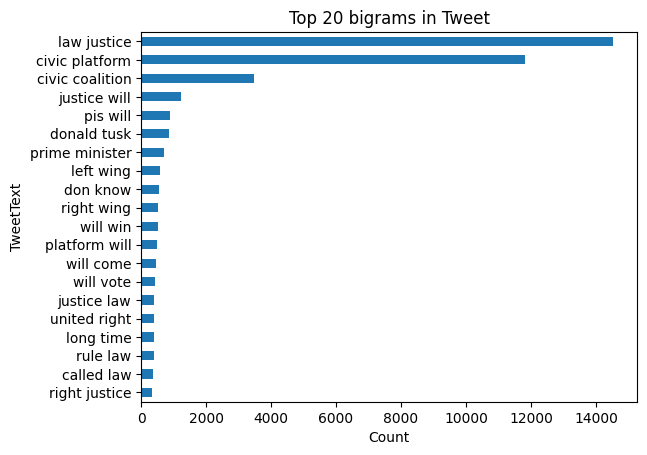

In [52]:
common_words = get_top_n_bigram(data['translated_tweet'], 20)

df1 = pd.DataFrame(common_words, columns=['TweetText', 'count'])
df1.groupby('TweetText').sum()['count'].sort_values(ascending=True).plot(
    kind='barh',
    xlabel='Count',
    title='Top 20 bigrams in Tweet'
);

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


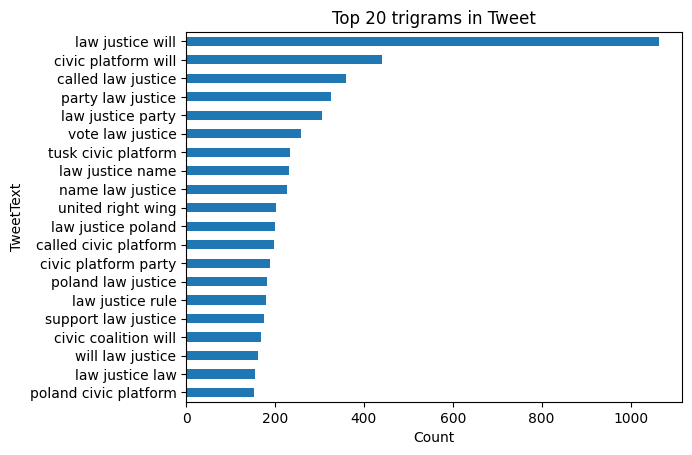

In [53]:
common_words = get_top_n_trigram(data['translated_tweet'], 20)

df2 = pd.DataFrame(common_words, columns=['TweetText', 'count'])
df2.groupby('TweetText').sum()['count'].sort_values(ascending=True).plot(
    kind='barh',
    xlabel='Count',
    title='Top 20 trigrams in Tweet'
);

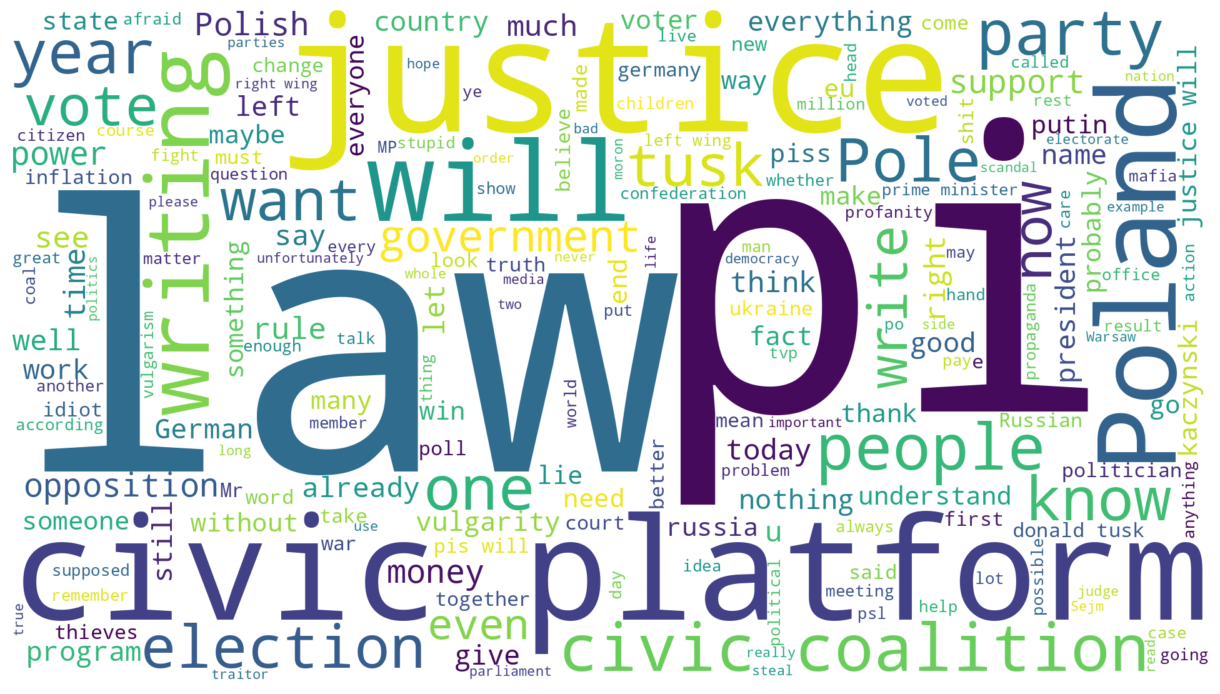

In [155]:
all_words = ' '.join([word for word in data['translated_tweet']])
make_word_cloud(all_words)

# Sentiment Analysis

First we will filter the stopwords from our translated tweets, and then we will use SentimentIntensityAnalyzer from NLTK to get the sentiment of our tweets.

In [56]:
# Instantiate sentiment analyzer
sid = SentimentIntensityAnalyzer()

In [61]:
# Filter stopwords
po_data["translated_tweet"] = po_data["translated_tweet"].apply(lambda x: filter_stopwords(str(x)))
pis_data["translated_tweet"] = pis_data["translated_tweet"].apply(lambda x: filter_stopwords(str(x)))

In [62]:
po_data.sample(n=10)["translated_tweet"].apply(print)

man will legend one day thieves amp
well example bricks building houses now cheaper tv years ago looking fuel year price now less lowering pit didnt vote matter supposedly citizen
religious war tvn agora civic platform hit catholics jpii book movie jpii long time ago planned time election campaign hanba action developed ambushing jpii niesiolowski destroy jpii monuments hanba
civic platform responsible electoral result civic platform feeling tomorrow will write something completely different
anticivic platform psl fired teachers hygienist psychologists fired liquidated schools now law justice accept new teachers psychologists bad psychologists will admitted according demand
wanted let german army poland back door civic platform german profanity
germany years civic platform psl collapsed polish statehood closing polish police stations post offices communication wonder germany today finances various chutzpah
civic coalition traitors liars thieves scammers pedophiles adventurers vandals n

18133    None
553      None
19242    None
15371    None
16322    None
12377    None
6742     None
21068    None
9921     None
14850    None
Name: translated_tweet, dtype: object

In [63]:
pis_data.sample(n=10)["translated_tweet"].apply(print)

pzpr activists used lot thanks pis less influence
foundations name party law justice policemans uniform robber truck robbery inside hypocrisy hypocrisy unprecedented polish history theft complete lack competence face
thats basically nowhere run change power will come suddenly property right will cease exist people will still say social justice
activities government consciously destroying poland poles
usual state weak draw conclusions law justice
applies larger ones writing rule
hello kind law justice law incompetent stranger copy posts social networking sites store computer phone time publish social profile
enter account zus check name account entire amount offer live see payment relatives inherit amount taken pis increase minimum wage calculate
hasnt charge years
course life better law justice rule rule tusk tragedy people left country en masse tagra dark times never tusk power amen


22490    None
29499    None
33479    None
13890    None
4182     None
15985    None
37862    None
3373     None
6498     None
19291    None
Name: translated_tweet, dtype: object

In [67]:
# Lemmatize
po_data["lem_translated_tweet"] = po_data["translated_tweet"].apply(lambda x: lemmatize(str(x)))
pis_data["lem_translated_tweet"] = pis_data["translated_tweet"].apply(lambda x: lemmatize(str(x)))

Let's apply the sentiment analyzer to our tweets

In [70]:
po_data["sentiment"] = po_data["lem_translated_tweet"].apply(lambda x: sid.polarity_scores(x)['compound'])
pis_data["sentiment"] = pis_data["lem_translated_tweet"].apply(lambda x: sid.polarity_scores(x)['compound'])

### Visualizing number of tweets in a sentiment category

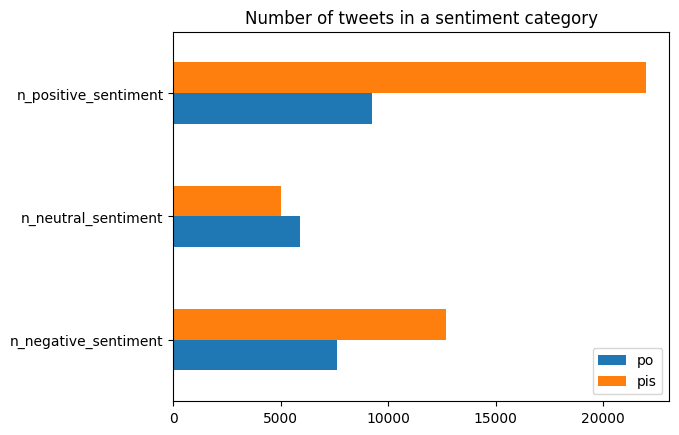

In [71]:
sentiment_count = pd.DataFrame(index=[0, 1],
                               columns=["n_negative_sentiment", "n_neutral_sentiment", "n_positive_sentiment"])

sentiment_count.at[0, "n_negative_sentiment"] = len(po_data[po_data["sentiment"] < 0])
sentiment_count.at[0, "n_neutral_sentiment"] = len(po_data[po_data["sentiment"] == 0])
sentiment_count.at[0, "n_positive_sentiment"] = len(po_data[po_data["sentiment"] > 0])
sentiment_count.at[1, "n_negative_sentiment"] = len(pis_data[pis_data["sentiment"] < 0])
sentiment_count.at[1, "n_neutral_sentiment"] = len(pis_data[pis_data["sentiment"] == 0])
sentiment_count.at[1, "n_positive_sentiment"] = len(pis_data[pis_data["sentiment"] > 0])

sentiment_count.index = ["po", "pis"]

sentiment_count.T.plot(kind='barh', title="Number of tweets in a sentiment category");

### Visualizing percent of tweets in a sentiment category

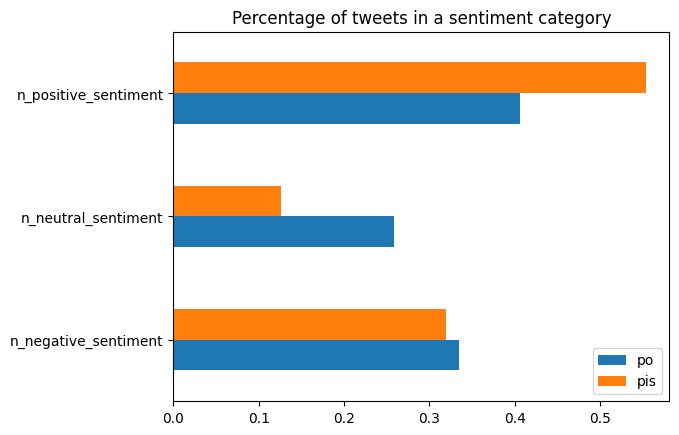

In [72]:
sentiment_count_percent = pd.DataFrame(index=[0, 1],
                               columns=["n_negative_sentiment", "n_neutral_sentiment", "n_positive_sentiment"])

sentiment_count_percent.iloc[0] = sentiment_count.loc["po"] / len(po_data)
sentiment_count_percent.iloc[1] = sentiment_count.loc["pis"] / len(pis_data)

sentiment_count_percent.index = ["po", "pis"]

sentiment_count_percent.T.plot(kind='barh', title="Percentage of tweets in a sentiment category");

From the above we can conclude that overall sentiment of PiS is higher than it is for a PO party.
PO have more neutral and negative sentiment (in percentage) than PiS.

In [73]:
# Splitting data into dataframes with neutral sentiment and without
# We also add a datetime column with a date of a week the day was in
po_result_non_zero_sentiment = po_data.groupby(po_data[po_data["sentiment"] != 0]["date"]).mean(numeric_only=True)
po_result = po_data.groupby(po_data["date"]).mean(numeric_only=True)
po_result_non_zero_sentiment['datetime'] = pd.to_datetime(po_result_non_zero_sentiment.index) - pd.to_timedelta(7, unit='d')
po_result['datetime'] = pd.to_datetime(po_result.index) - pd.to_timedelta(7, unit='d')

pis_result_non_zero_sentiment = pis_data.groupby(pis_data[pis_data["sentiment"] != 0]["date"]).mean(numeric_only=True)
pis_result = pis_data.groupby(pis_data["date"]).mean(numeric_only=True)
pis_result_non_zero_sentiment['datetime'] = pd.to_datetime(pis_result_non_zero_sentiment.index) - pd.to_timedelta(7, unit='d')
pis_result['datetime'] = pd.to_datetime(po_result.index) - pd.to_timedelta(7, unit='d')

# Sentiment Visualization

## Daily Sentiment

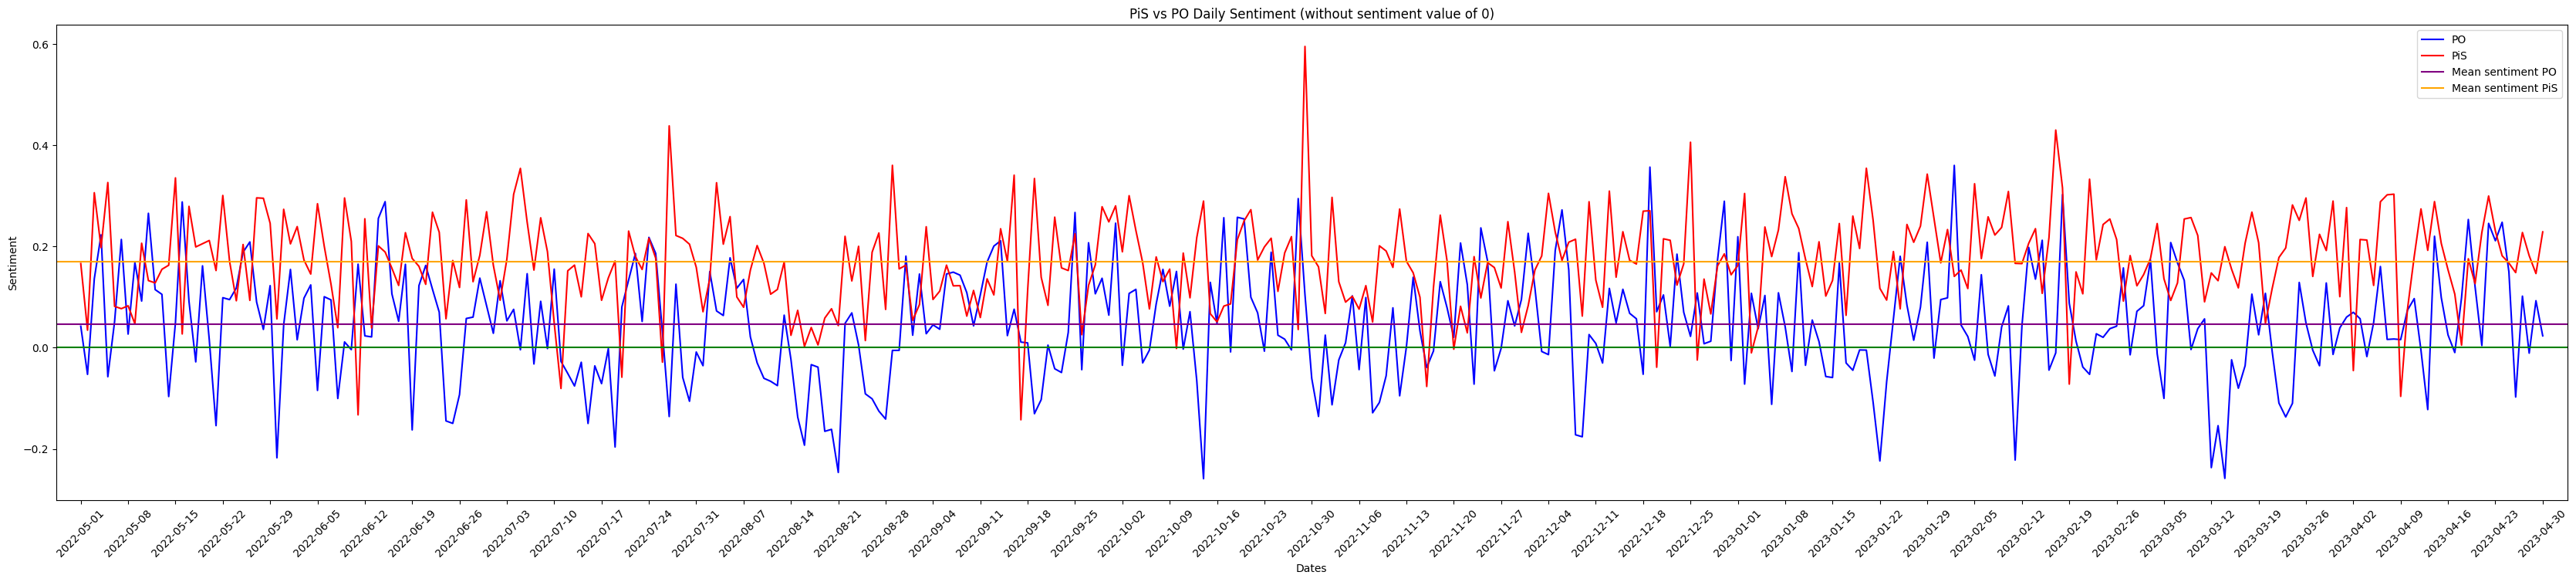

In [168]:
fig, ax = plt.subplots(figsize=(42, 8))
ax.plot(po_result_non_zero_sentiment.index, po_result_non_zero_sentiment["sentiment"], c='b', label='PO')
ax.plot(pis_result_non_zero_sentiment.index, pis_result_non_zero_sentiment["sentiment"], c='r', label='PiS')

ax.set_xlabel('Dates')
ax.set_ylabel('Sentiment')
ax.set_title('PiS vs PO Daily Sentiment (without sentiment value of 0)')
ax.axhline(y=0, c='g')
ax.axhline(y=np.mean(po_result_non_zero_sentiment["sentiment"]), label='Mean sentiment PO', c='purple')
ax.axhline(y=np.mean(pis_result_non_zero_sentiment["sentiment"]), label='Mean sentiment PiS', c='orange')
plt.xticks(pis_result_non_zero_sentiment.index[::7], rotation=45)
ax.margins(x=0.01)
plt.legend();

plt.show();

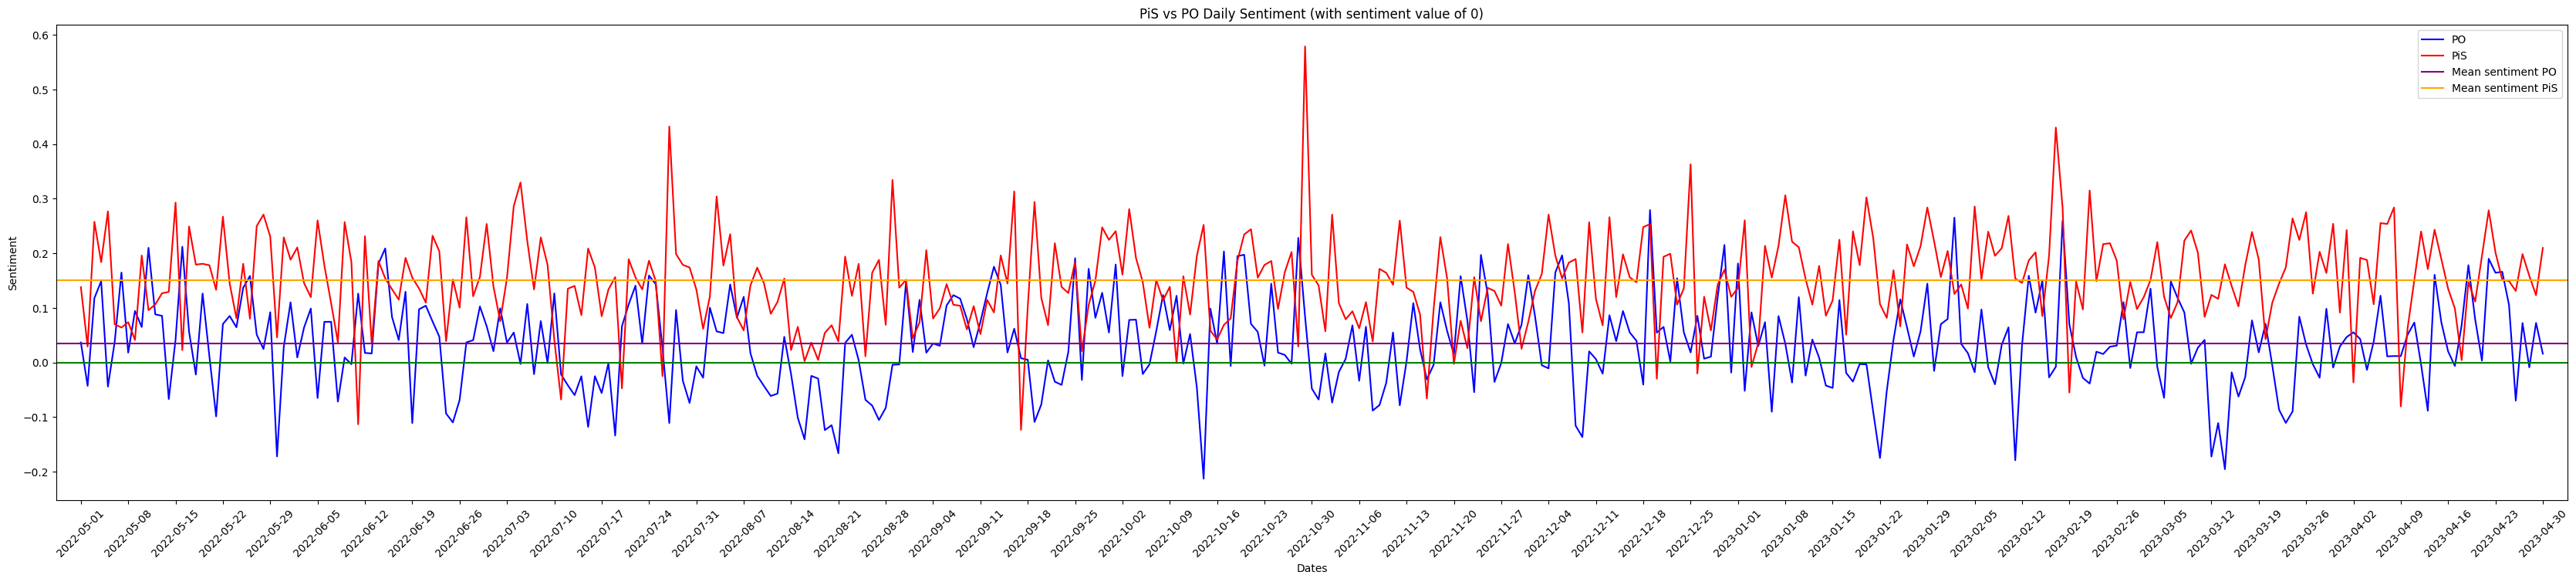

In [75]:
fig, ax = plt.subplots(figsize=(42, 8))
ax.plot(po_result.index, po_result["sentiment"], c='b', label='PO')
ax.plot(pis_result.index, pis_result["sentiment"], c='r', label='PiS')

ax.set_xlabel('Dates')
ax.set_ylabel('Sentiment')
ax.set_title('PiS vs PO Daily Sentiment (with sentiment value of 0)')
ax.axhline(y=0, c='g')
ax.axhline(y=np.mean(po_result["sentiment"]), label='Mean sentiment PO', c='purple')
ax.axhline(y=np.mean(pis_result["sentiment"]), label='Mean sentiment PiS', c='orange')
plt.xticks(pis_result.index[::7], rotation=45)
ax.margins(x=0.01)
plt.legend();

plt.show();

## Weekly Sentiment

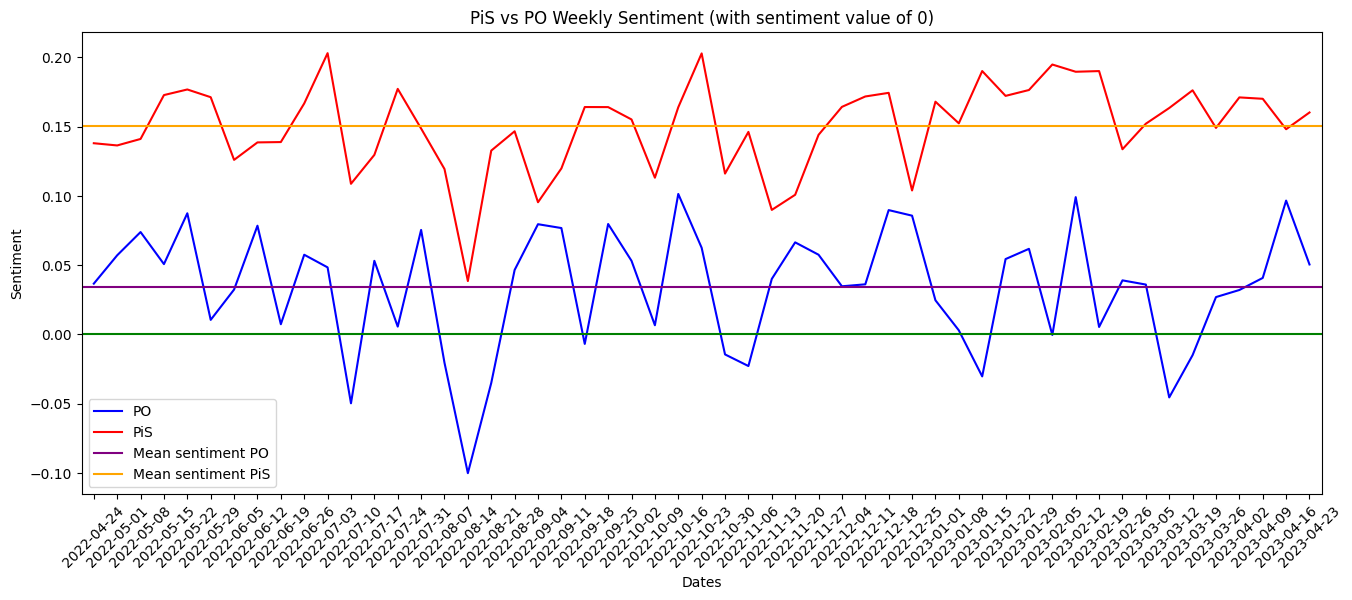

In [76]:
weekly_po_data = po_result.groupby([pd.Grouper(key='datetime', freq='W')])['sentiment'].mean()
weekly_pis_data = pis_result.groupby([pd.Grouper(key='datetime', freq='W')])['sentiment'].mean()

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(weekly_po_data.index, weekly_po_data, c='b', label='PO')
ax.plot(weekly_pis_data.index, weekly_pis_data, c='r', label='PiS')

ax.set_xlabel('Dates')
ax.set_ylabel('Sentiment')
ax.set_title('PiS vs PO Weekly Sentiment (with sentiment value of 0)')
ax.axhline(y=0, c='g')
ax.axhline(y=np.mean(weekly_po_data), label='Mean sentiment PO', c='purple')
ax.axhline(y=np.mean(weekly_pis_data), label='Mean sentiment PiS', c='orange')
plt.xticks(weekly_po_data.index, rotation=45)
ax.margins(x=0.01)
plt.legend();

plt.show();

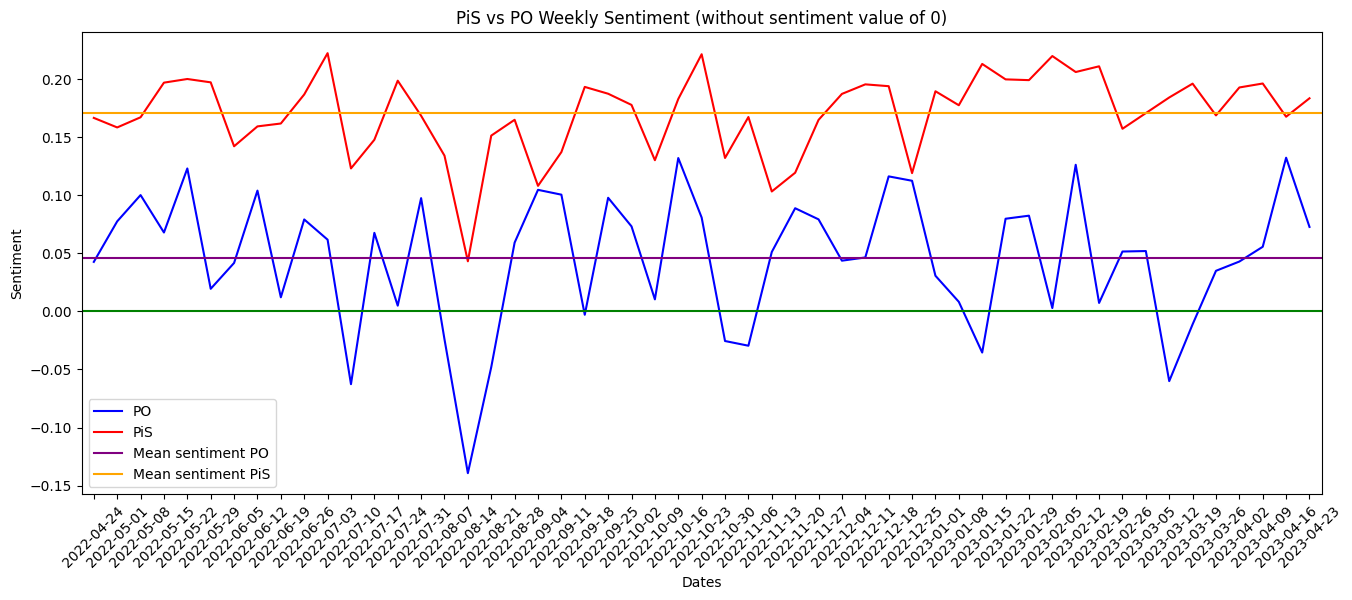

In [77]:
weekly_po_data = po_result_non_zero_sentiment.groupby([pd.Grouper(key='datetime', freq='W')])['sentiment'].mean()
weekly_pis_data = pis_result_non_zero_sentiment.groupby([pd.Grouper(key='datetime', freq='W')])['sentiment'].mean()

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(weekly_po_data.index, weekly_po_data, c='b', label='PO')
ax.plot(weekly_pis_data.index, weekly_pis_data, c='r', label='PiS')

ax.set_xlabel('Dates')
ax.set_ylabel('Sentiment')
ax.set_title('PiS vs PO Weekly Sentiment (without sentiment value of 0)')
ax.axhline(y=0, c='g')
ax.axhline(y=np.mean(weekly_po_data), label='Mean sentiment PO', c='purple')
ax.axhline(y=np.mean(weekly_pis_data), label='Mean sentiment PiS', c='orange')
plt.xticks(weekly_po_data.index, rotation=45)
ax.margins(x=0.01)
plt.legend();

plt.show();

## Monthly Sentiment

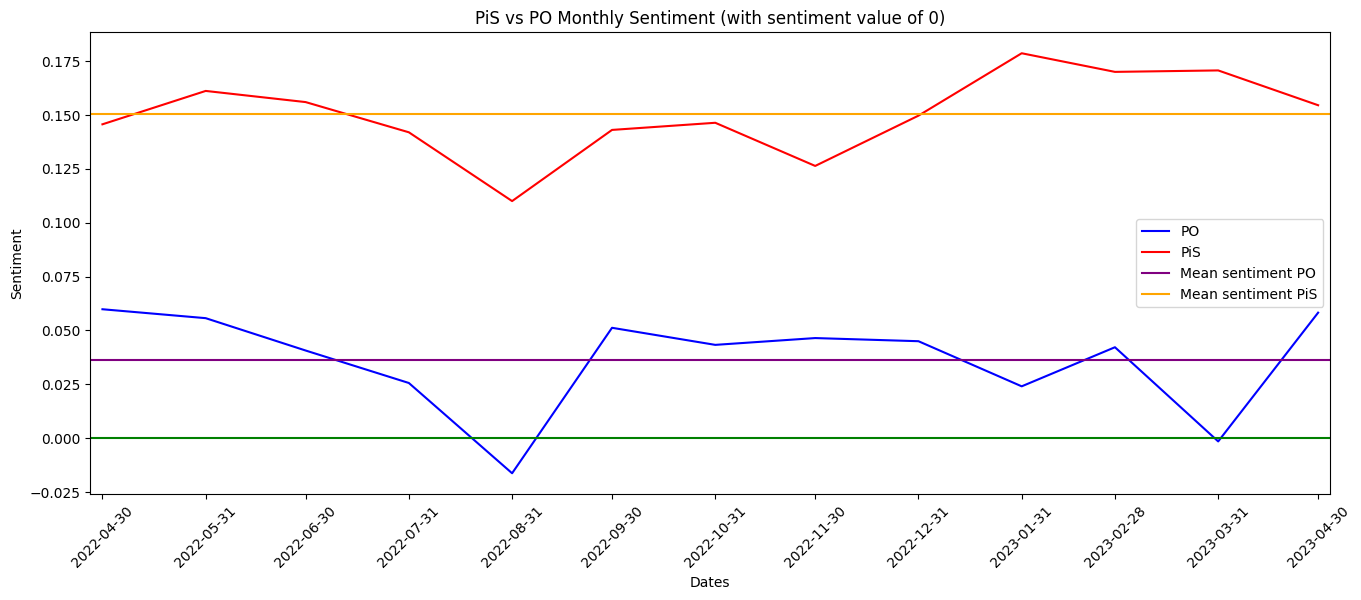

In [78]:
monthly_po_data = po_result.groupby([pd.Grouper(key='datetime', freq='M')])['sentiment'].mean()
monthly_pis_data = pis_result.groupby([pd.Grouper(key='datetime', freq='M')])['sentiment'].mean()

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(monthly_po_data.index, monthly_po_data, c='b', label='PO')
ax.plot(monthly_pis_data.index, monthly_pis_data, c='r', label='PiS')

ax.set_xlabel('Dates')
ax.set_ylabel('Sentiment')
ax.set_title('PiS vs PO Monthly Sentiment (with sentiment value of 0)')
ax.axhline(y=0, c='g')
ax.axhline(y=np.mean(monthly_po_data), label='Mean sentiment PO', c='purple')
ax.axhline(y=np.mean(monthly_pis_data), label='Mean sentiment PiS', c='orange')
plt.xticks(monthly_po_data.index, rotation=45)
ax.margins(x=0.01)
plt.legend();

plt.show();

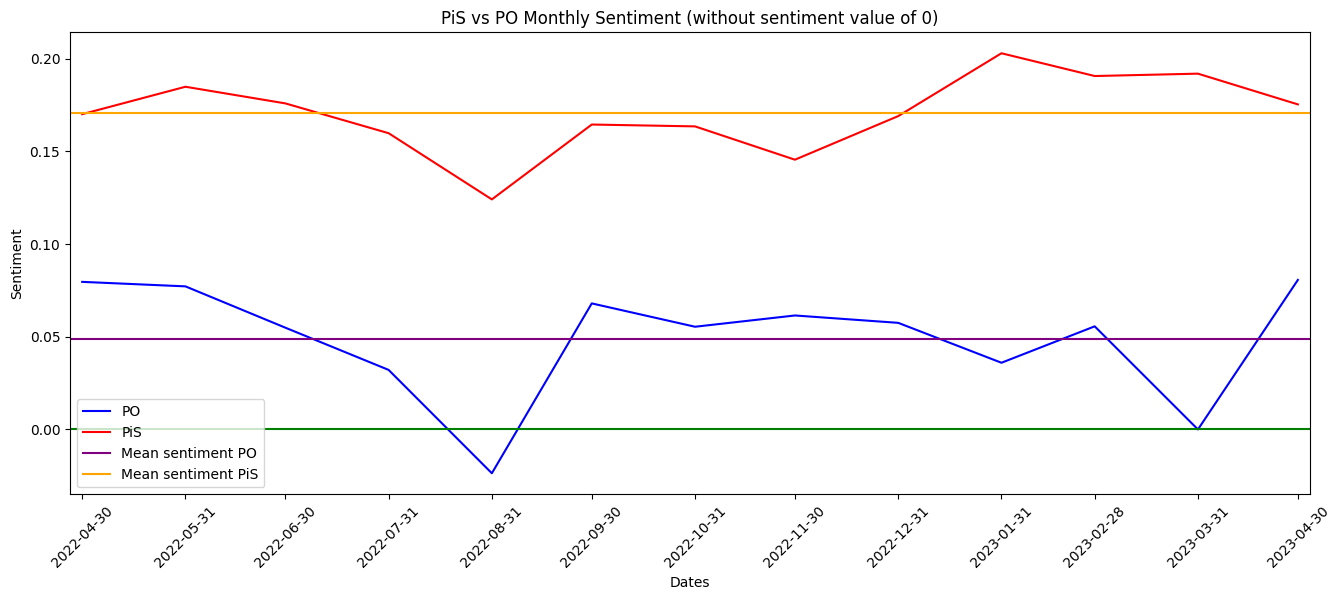

In [79]:
monthly_po_data = po_result_non_zero_sentiment.groupby([pd.Grouper(key='datetime', freq='M')])['sentiment'].mean()
monthly_pis_data = pis_result_non_zero_sentiment.groupby([pd.Grouper(key='datetime', freq='M')])['sentiment'].mean()

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(monthly_po_data.index, monthly_po_data, c='b', label='PO')
ax.plot(monthly_pis_data.index, monthly_pis_data, c='r', label='PiS')

ax.set_xlabel('Dates')
ax.set_ylabel('Sentiment')
ax.set_title('PiS vs PO Monthly Sentiment (without sentiment value of 0)')
ax.axhline(y=0, c='g')
ax.axhline(y=np.mean(monthly_po_data), label='Mean sentiment PO', c='purple')
ax.axhline(y=np.mean(monthly_pis_data), label='Mean sentiment PiS', c='orange')
plt.xticks(monthly_po_data.index, rotation=45)
ax.margins(x=0.01)
plt.legend();

plt.show();

Here we can see the confirmation of the assumption we made above - overall mean sentiment for PiS is higher than it is for PO.

### Visualizing some sentiment statistics

We will visualize histograms with distribution of sentiments and basic statistics such as min and max sentiments, median and also mean sentiments for each of the groups (non zero sentiment group and group with 0 sentiments).

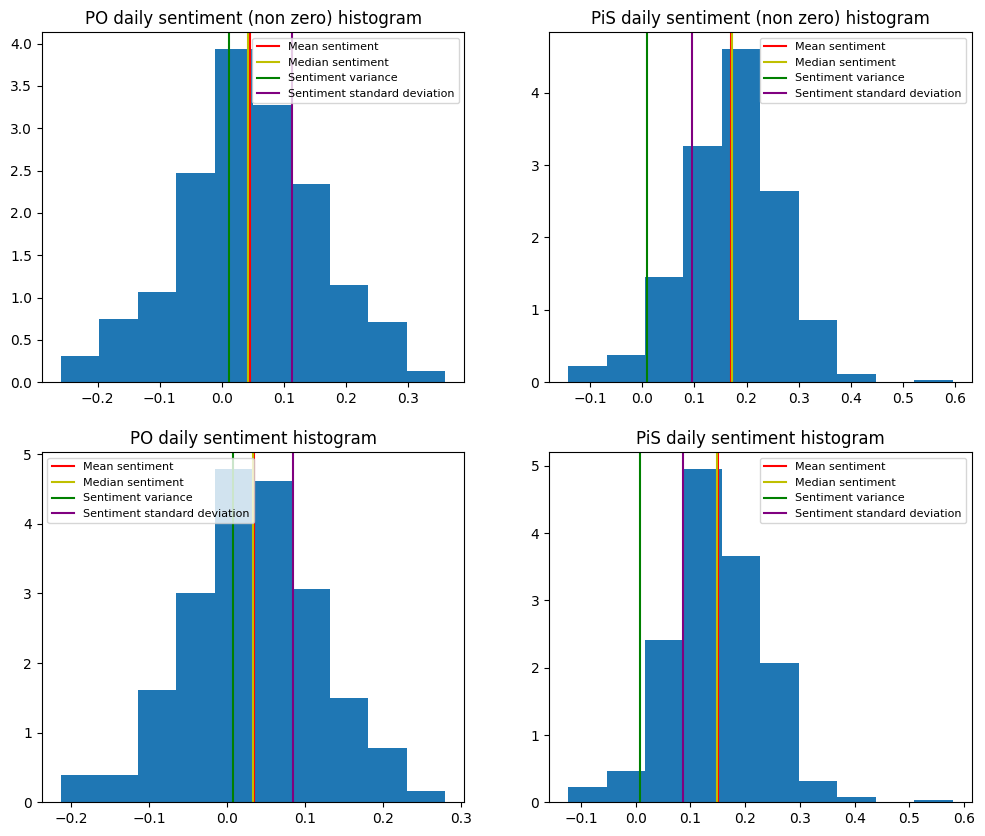

In [80]:
fig, ax = plt.subplots(nrows=2,
                       ncols=2,
                       figsize=(12, 10))

plot_hist(ax[0][0], po_result_non_zero_sentiment["sentiment"], title="PO daily sentiment (non zero) histogram")
plot_hist(ax[1][0], po_result["sentiment"], title="PO daily sentiment histogram")
plot_hist(ax[0][1], pis_result_non_zero_sentiment["sentiment"], title="PiS daily sentiment (non zero) histogram")
plot_hist(ax[1][1], pis_result["sentiment"], title="PiS daily sentiment histogram")

In [81]:
results = pd.DataFrame(index=[0, 1],
                       columns=["average_sentiment", "median_sentiment", "average_non_zero_sentiment", "median_non_zero_sentiment", "min_sentiment", "max_sentiment"])

results.at[0, "average_sentiment"] = np.mean(po_result["sentiment"])
results.at[0, "average_non_zero_sentiment"] = np.mean(po_result_non_zero_sentiment["sentiment"])
results.at[0, "median_sentiment"] = np.median(po_result["sentiment"])
results.at[0, "median_non_zero_sentiment"] = np.median(po_result_non_zero_sentiment["sentiment"])
results.at[0, "min_sentiment"] = np.min(po_result["sentiment"])
results.at[0, "max_sentiment"] = np.max(po_result["sentiment"])

results.at[1, "average_sentiment"] = np.mean(pis_result["sentiment"])
results.at[1, "average_non_zero_sentiment"] = np.mean(pis_result_non_zero_sentiment["sentiment"])
results.at[1, "median_sentiment"] = np.median(pis_result["sentiment"])
results.at[1, "median_non_zero_sentiment"] = np.median(pis_result_non_zero_sentiment["sentiment"])
results.at[1, "min_sentiment"] = np.min(pis_result["sentiment"])
results.at[1, "max_sentiment"] = np.max(pis_result["sentiment"])

results.index = ["po", "pis"]

results

average_sentiment median_sentiment average_non_zero_sentiment  \
po           0.034327         0.032928                    0.04594   
pis          0.150422          0.14911                   0.170539   

    median_non_zero_sentiment min_sentiment max_sentiment  
po                   0.043017     -0.212927      0.279184  
pis                  0.171586     -0.123372      0.578893

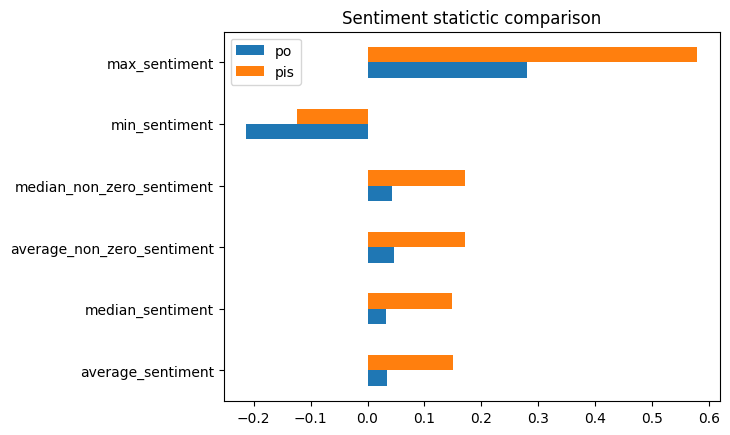

In [87]:
results.T.plot(kind='barh', title="Sentiment statictic comparison");

## Word clouds for positive and negative sentiments

### Positive PO sentiment

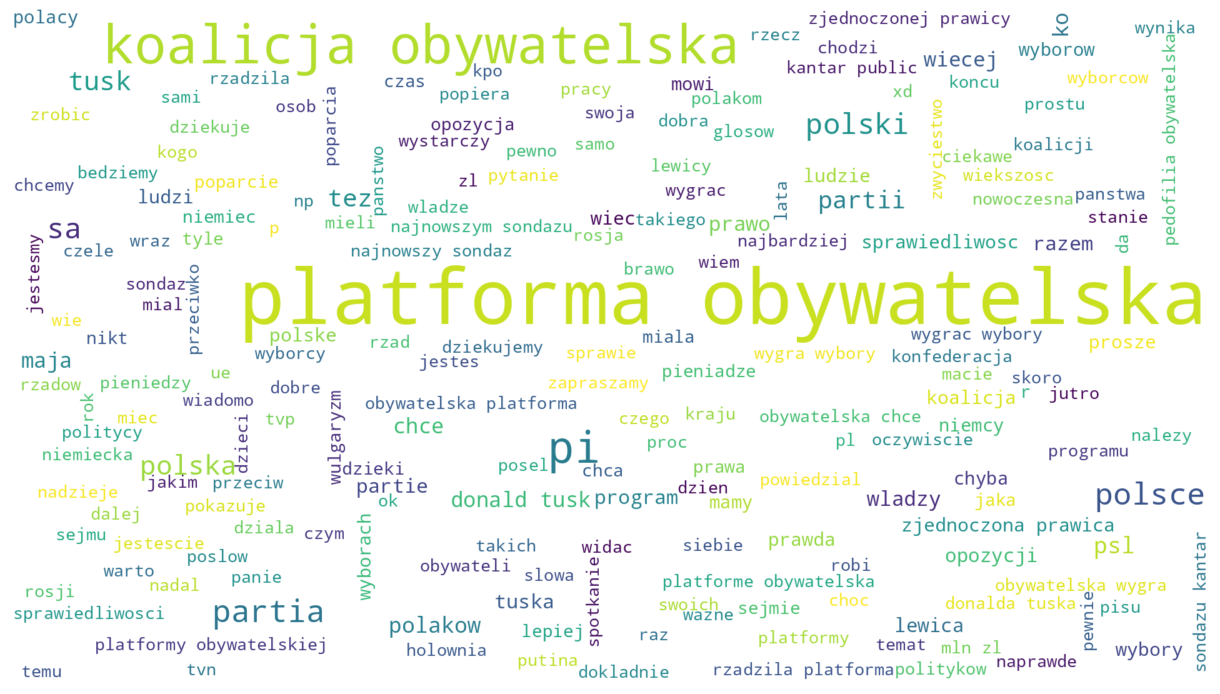

In [156]:
positive_po_words = ' '.join([word for word in po_data[po_data["sentiment"] > 0]["tweet"]])
make_word_cloud(positive_po_words, stopwords=polish_stop_words)

### Positive PiS Sentiment

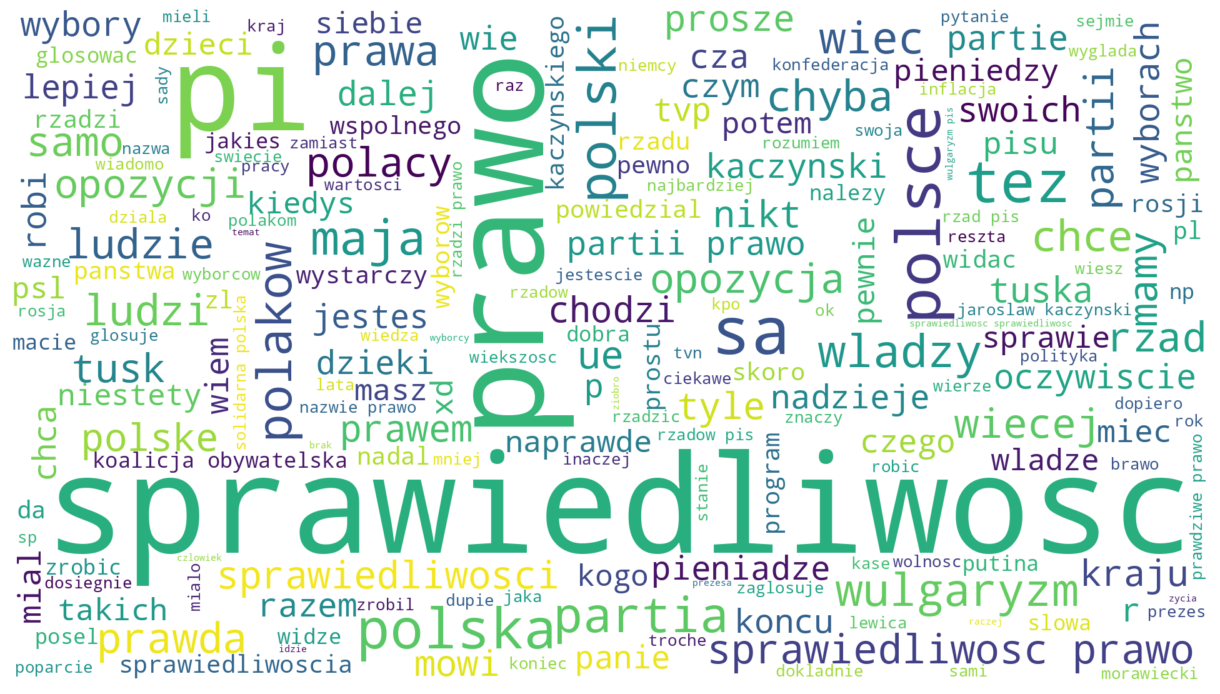

In [157]:
positive_pis_words = ' '.join([word for word in pis_data[pis_data["sentiment"] > 0]["tweet"]])
make_word_cloud(positive_pis_words, stopwords=polish_stop_words)

### Negative PO Sentiment

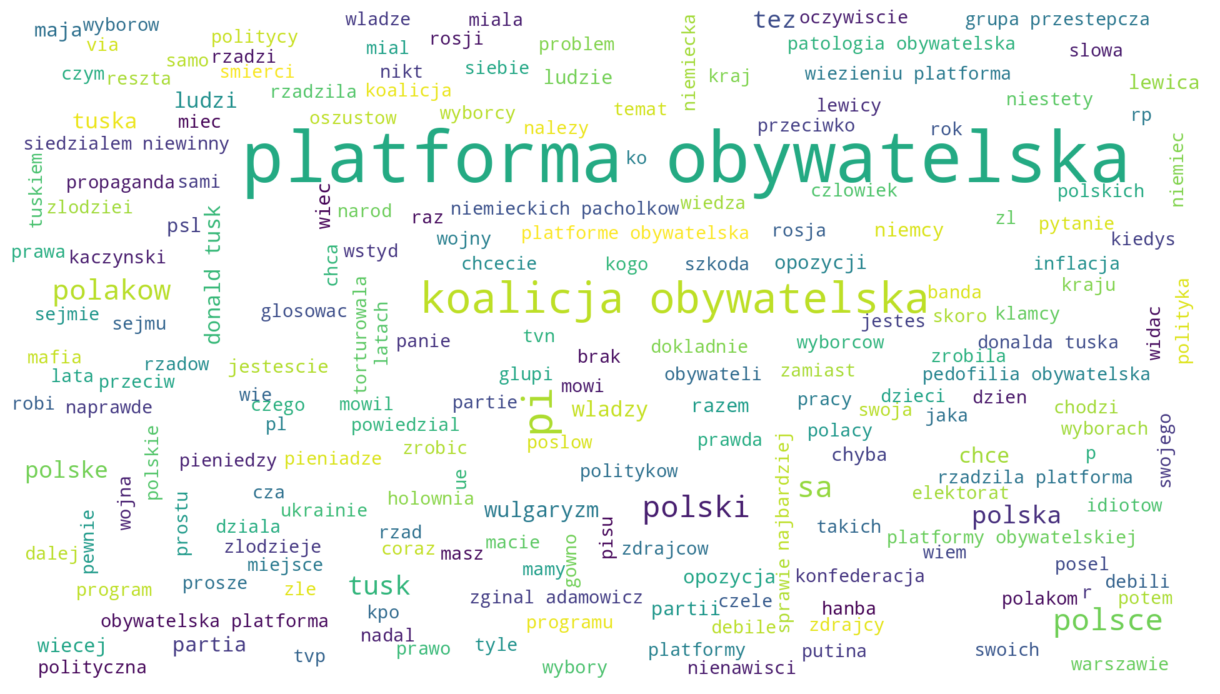

In [158]:
negative_po_words = ' '.join([word for word in po_data[po_data["sentiment"] < 0]["tweet"]])
make_word_cloud(negative_po_words, stopwords=polish_stop_words)

### Negative PiS Sentiment

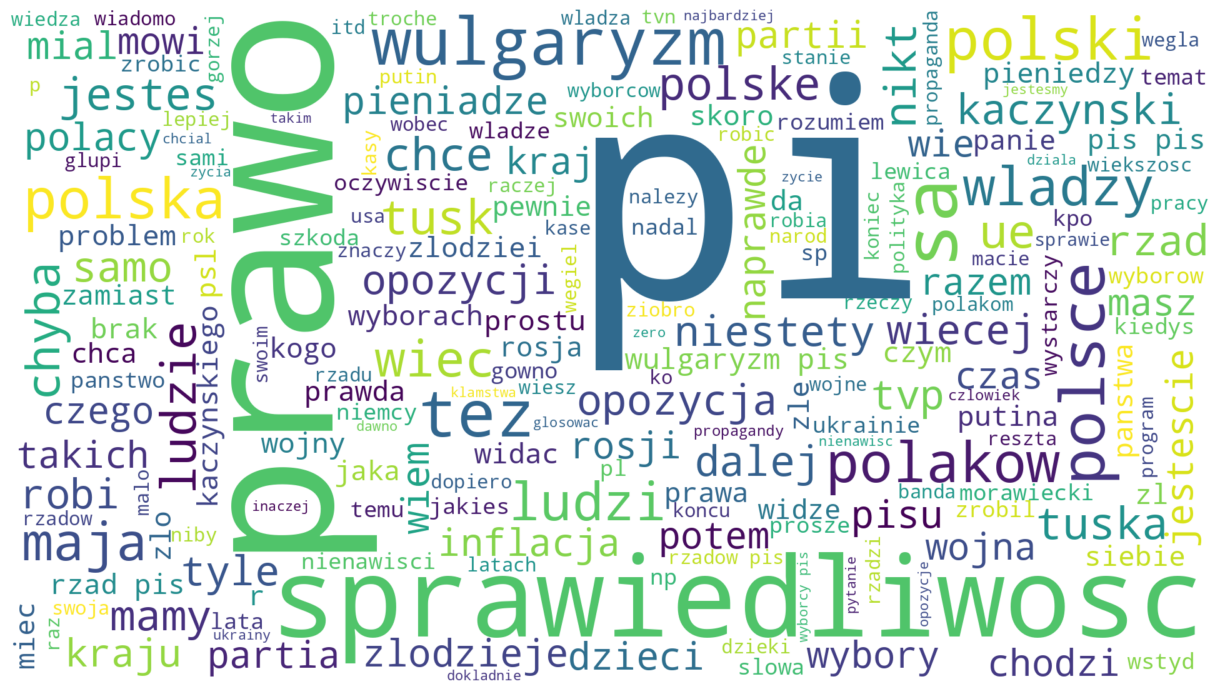

In [159]:
negative_pis_words = ' '.join([word for word in pis_data[pis_data["sentiment"] < 0]["tweet"]])
make_word_cloud(negative_pis_words, stopwords=polish_stop_words)

# Emotion extraction

In this part we will extract emotions from out tweets using text2emotion. We assign the first emotion with maximum value to the tweet.

In [113]:
po_data["emotion"] = po_data["translated_tweet"].apply(get_emotion)

In [163]:
po_data.sample(n=10)

Unnamed: 0.1  Unnamed: 0        date  \
9229          26712       26712  2022-10-21   
1124           3716        3716  2022-05-27   
18562         52093       52093  2023-03-14   
18537         51938       51938  2023-03-14   
3383           9728        9728  2022-07-04   
6167          17855       17855  2022-08-26   
7580          21913       21913  2022-09-22   
10367         29458       29458  2022-11-05   
7480          21597       21597  2022-09-19   
6067          17563       17563  2022-08-24   

                                                   tweet  \
9229   macie problem tusk ma problem cala patologia o...   
1124      dowody na co na to ze platforma jest platforma   
18562  hieny tysiaclecia to platforma obywatelska raz...   
18537  platforma obywatelska widziala ze kobiete mozn...   
3383   dzis w radomiu czuc bylo energie i wiatr zmian...   
6167   oni slowa przepraszam nie ogarniaja za chwile ...   
7580   taka jak matka zatem prezydencie czy to zoska ...   
10367  o i uchwyciles istote koalicji zp ze ziobro gl...   
7480   oto platforma obywatelska w realu fake news i ...   
6067   w poznaniu od wielu lat rzadzi platforma obywa...   

                                          original_tweet  reply_count  \
9229   @Platforma_org @donaldtusk Macie problem, Tusk...            0   
1124   @CHARZYNSKIKAROL @JakubDudek97 @zuzannaszewczy...            1   
18562  @pomaska HIENY TYSIĄCLECIA TO PLATFORMA OBYWAT...            0   
18537  Platforma obywatelska widziała że kobiete możn...            7   
3383   Dziś w Radomiu czuć było energię i wiatr zmian...           17   
6167   @KrystPawlowicz @LechNowacki @donaldtusk Oni s...           13   
7580   @ARomasze taka jak matka ZATEM prezydencie  cz...            0   
10367  @Szymon1985 @Janek_USA @AdamMofina @MarcinPala...            1   
7480   Oto Platforma Obywatelska w realu. Fake news i...            0   
6067   @dobrogowski_ W Poznaniu od wielu lat rządzi P...            0   

       retweet_count  like_count  quote_count party  \
9229               0           0            0    po   
1124               0           1            0    po   
18562              1           2            0    po   
18537             17          50            2    po   
3383              23          86            4    po   
6167               1          31            0    po   
7580               0           2            0    po   
10367              0           0            0    po   
7480               0           1            0    po   
6067               0           0            0    po   

                                        translated_tweet  \
9229   problem tusk problem civic pathology problem w...   
1124                          evidence platform platform   
18562      hyenas millennium civic platform together tvn   
18537  civic platform saw woman used pedophile case n...   
3383   today radom feel energy wind change entire civ...   
6167   understand words sorry moment will manipulate ...   
7580   mother president zoska persuaded two vetoes do...   
10367  o captured essence zp coalition rib votes kacz...   
7480   civic platform real fake news toilet backgroun...   
6067             poznan civic platform ruling many years   

                                    lem_translated_tweet  sentiment emotion  
9229   problem tusk problem civic pathology problem w...    -0.3818    Fear  
1124                          evidence platform platform     0.0000    Fear  
18562       hyena millennium civic platform together tvn     0.0000   Happy  
18537  civic platform saw woman used pedophile case n...    -0.7650     Sad  
3383   today radom feel energy wind change entire civ...     0.9559    Fear  
6167   understand word sorry moment will manipulate a...    -0.0516   Angry  
7580   mother president zoska persuaded two veto dona...     0.0000     Sad  
10367  o captured essence zp coalition rib vote kaczy...     0.7351    Fear  
7480   civic platform real fake news toilet backgroun..

In [116]:
pis_data["emotion"] = pis_data["translated_tweet"].apply(get_emotion)

In [165]:
pis_data.sample(n=10)

Unnamed: 0.1  Unnamed: 0        date  \
28744         44480       44480  2023-02-02   
24798         38414       38414  2022-12-30   
5592           8562        8562  2022-06-27   
29839         46206       46206  2023-02-11   
23690         36689       36689  2022-12-17   
2897           4217        4217  2022-05-30   
12067         18416       18416  2022-08-30   
2867           4187        4187  2022-05-30   
25718         39635       39635  2023-01-06   
24029         37307       37307  2022-12-21   

                                                   tweet  \
28744  nadal zyjemy dawnymi uprzedzeniami i resentyme...   
24798  klamstwa na wielu poziomach rowniez o ukrainie...   
5592   wiecie nawet nie tyle brak pomyslu waszych ido...   
29839  brat komendanta granatnika stworzyl mafie vat ...   
23690  zabierane dzieci na mecze z domow dziecka w me...   
2897   zbieranie chrustu plus taki nieformalny progra...   
12067  mam cie zasypac transparentami i haslami z was...   
2867                                  pis jeszcze gorszy   
25718  oto pluralizm mediow wg pis tusk ich tak wypos...   
24029  ale o co chodzi fundacja rodzinna pis na czas ...   

                                          original_tweet  reply_count  \
28744  "Nadal żyjemy dawnymi uprzedzeniami i resentym...            1   
24798  @LeskiPiotr Klamstwa na wielu poziomach. Równi...            0   
5592   @Ewa_Blukacz @unnamed56885400 @Przem75 @OloCza...            1   
29839  @Darek38672331 @lis_tomasz Brat komendanta Gra...            1   
23690  @JoannaS24297518 Zabierane dzieci na mecze z d...            0   
2897   @JakubBierzynski Zbieranie chrustu PLUS.\nTaki...            0   
12067  @SzDanielczyk @Prokurent74 @pisorgpl @TVP @PL_...            1   
2867                  @Tomek69249845 pis jeszcze gorszy.            0   
25718  Oto pluralizm mediów wg PiS. Tusk ich tak wypo...            0   
24029  @OlgaEwaSemeniuk Ale o co chodzi?\n\nFundacja ...            0   

       retweet_count  like_count  quote_count party  \
28744              4          18            0   pis   
24798              0           0            0   pis   
5592               0           0            0   pis   
29839              0           0            0   pis   
23690              0           1            0   pis   
2897               0           6            0   pis   
12067              0           0            0   pis   
2867               0           2            0   pis   
25718              0           0            0   pis   
24029              0           0            0   pis   

                                        translated_tweet  \
28744  still live old prejudices resentments maintain...   
24798  lies many levels ukraine pis assumed quick def...   
5592   know much lack ideas idols dissuades voting at...   
29839  brother grenade launcher commander created vat...   
23690  children taken matches orphanages media silenc...   
2897   collecting brushwood plus informal program pis...   
12067  im supposed shower banners slogans rallies dem...   
2867                                    write even worse   
25718  pluralism media according pis tusk relieved te...   
24029                 family foundation writes time loss   

                                    lem_translated_tweet  sentiment   emotion  
28744  still live old prejudice resentment maintain a...    -0.1531  Surprise  
24798  lie many level ukraine pi assumed quick defeat...    -0.1531       Sad  
5592   know much lack idea idol dissuades voting atti...    -0.9022     Angry  
29839  brother grenade launcher commander created vat...     0.6597  Surprise  
23690  child taken match orphanage medium silence rep...     0.3262  Surprise  
2897   collecting brushwood plus informal program pi ...    -0.4404       Sad  
12067  im supposed shower banner slogan rally demonst...    -0.4588      Fear  
2867                                    write even worse    -0.4767       Sad  
25718  pluralism medium according pi 

In [119]:
pis_data.to_excel("/content/drive/MyDrive/ML-tweet-analysis/pis_data_unique_translated_sent_emot.xlsx")
po_data.to_excel("/content/drive/MyDrive/ML-tweet-analysis/po_data_unique_translated_sent_emot.xlsx")

## Emotion Visualization

First up we will visualize number of different emotions and percentage of them.

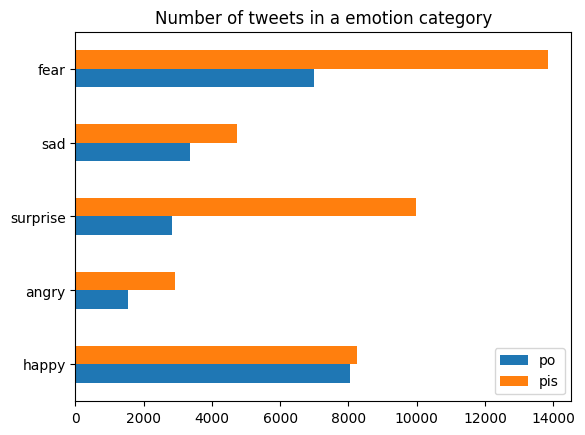

In [120]:
emotion_count = pd.DataFrame(index=[0, 1],
                               columns=["happy", "angry", "surprise", "sad", "fear"])

emotion_count.at[0, "happy"] = len(po_data[po_data["emotion"] == 'Happy'])
emotion_count.at[0, "angry"] = len(po_data[po_data["emotion"] == 'Angry'])
emotion_count.at[0, "surprise"] = len(po_data[po_data["emotion"] == 'Surprise'])
emotion_count.at[0, "sad"] = len(po_data[po_data["emotion"] == 'Sad'])
emotion_count.at[0, "fear"] = len(po_data[po_data["emotion"] == 'Fear'])
emotion_count.at[1, "happy"] = len(pis_data[pis_data["emotion"] == 'Happy'])
emotion_count.at[1, "angry"] = len(pis_data[pis_data["emotion"] == 'Angry'])
emotion_count.at[1, "surprise"] = len(pis_data[pis_data["emotion"] == 'Surprise'])
emotion_count.at[1, "sad"] = len(pis_data[pis_data["emotion"] == 'Sad'])
emotion_count.at[1, "fear"] = len(pis_data[pis_data["emotion"] == 'Fear'])

emotion_count.index = ["po", "pis"]

emotion_count.T.plot(kind='barh', title="Number of tweets in a emotion category");

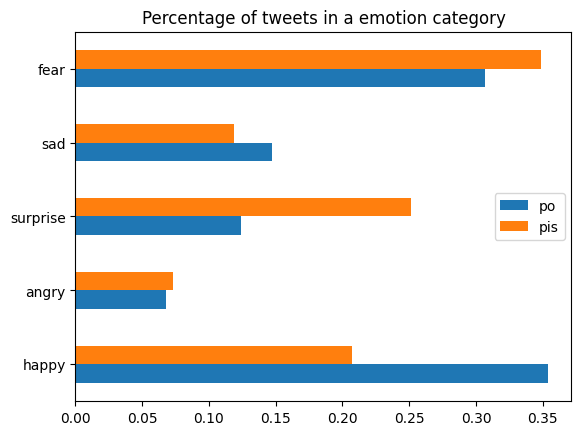

In [121]:
emotion_count_percent = pd.DataFrame(index=[0, 1],
                               columns=["happy", "angry", "surprise", "sad", "fear"])

emotion_count_percent.iloc[0] = emotion_count.loc["po"] / len(po_data)
emotion_count_percent.iloc[1] = emotion_count.loc["pis"] / len(pis_data)

emotion_count_percent.index = ["po", "pis"]

emotion_count_percent.T.plot(kind='barh', title="Percentage of tweets in a emotion category");

Let's sum up all the emotions from a given day and visualize them on a plot so that we could see which emotion was dominating.

In [141]:
pis_emotions = pis_data.groupby(pis_data["date"]).mean(numeric_only=True)
pis_emotions["happy"] = 0
pis_emotions["angry"] = 0
pis_emotions["surprise"] = 0
pis_emotions["sad"] = 0
pis_emotions["fear"] = 0

pis_emotions = pis_emotions[["happy", "angry", "surprise", "sad", "fear"]]
pis_emotions["formatted_date"] = pis_emotions.index
pis_emotions["happy"] = pis_emotions["formatted_date"].apply(lambda x: len(pis_data.loc[(pis_data["emotion"] == 'Happy') & (pis_data["date"] == x)]))
pis_emotions["angry"] = pis_emotions["formatted_date"].apply(lambda x: len(pis_data.loc[(pis_data["emotion"] == 'Angry') & (pis_data["date"] == x)]))
pis_emotions["surprise"] = pis_emotions["formatted_date"].apply(lambda x: len(pis_data.loc[(pis_data["emotion"] == 'Surprise') & (pis_data["date"] == x)]))
pis_emotions["sad"] = pis_emotions["formatted_date"].apply(lambda x: len(pis_data.loc[(pis_data["emotion"] == 'Sad') & (pis_data["date"] == x)]))
pis_emotions["fear"] = pis_emotions["formatted_date"].apply(lambda x: len(pis_data.loc[(pis_data["emotion"] == 'Fear') & (pis_data["date"] == x)]))

pis_emotions

happy  angry  surprise  sad  fear formatted_date
date                                                        
2022-05-01     25      7        21   12    23     2022-05-01
2022-05-02     21      6        18    8    30     2022-05-02
2022-05-03     24      7        53    9    39     2022-05-03
2022-05-04     19      9        29   13    28     2022-05-04
2022-05-05     24      7        34   11    42     2022-05-05
...           ...    ...       ...  ...   ...            ...
2023-04-26     47     13        62   30    77     2023-04-26
2023-04-27     49      7        64   34    79     2023-04-27
2023-04-28     49     17        51   23    64     2023-04-28
2023-04-29     54      9        50   20    49     2023-04-29
2023-04-30     35     11        46   19    79     2023-04-30

[365 rows x 6 columns]

In [142]:
po_emotions = po_data.groupby(po_data["date"]).mean(numeric_only=True)
po_emotions["happy"] = 0
po_emotions["angry"] = 0
po_emotions["surprise"] = 0
po_emotions["sad"] = 0
po_emotions["fear"] = 0

po_emotions = po_emotions[["happy", "angry", "surprise", "sad", "fear"]]
po_emotions["formatted_date"] = po_emotions.index
po_emotions["happy"] = po_emotions["formatted_date"].apply(lambda x: len(po_data.loc[(po_data["emotion"] == 'Happy') & (po_data["date"] == x)]))
po_emotions["angry"] = po_emotions["formatted_date"].apply(lambda x: len(po_data.loc[(po_data["emotion"] == 'Angry') & (po_data["date"] == x)]))
po_emotions["surprise"] = po_emotions["formatted_date"].apply(lambda x: len(po_data.loc[(po_data["emotion"] == 'Surprise') & (po_data["date"] == x)]))
po_emotions["sad"] = po_emotions["formatted_date"].apply(lambda x: len(po_data.loc[(po_data["emotion"] == 'Sad') & (po_data["date"] == x)]))
po_emotions["fear"] = po_emotions["formatted_date"].apply(lambda x: len(po_data.loc[(po_data["emotion"] == 'Fear') & (po_data["date"] == x)]))

po_emotions

happy  angry  surprise  sad  fear formatted_date
date                                                        
2022-05-01      7      3         5    4    10     2022-05-01
2022-05-02      4      2         2    4     4     2022-05-02
2022-05-03      4      1         3    3     4     2022-05-03
2022-05-04     12      3         4    2     9     2022-05-04
2022-05-05     29      8        13    8    12     2022-05-05
...           ...    ...       ...  ...   ...            ...
2023-04-26     82     11        20   18    42     2023-04-26
2023-04-27     71     13        21   20    36     2023-04-27
2023-04-28     38      2        17   22    35     2023-04-28
2023-04-29     54     11        14   30    59     2023-04-29
2023-04-30     37      8         9   13    31     2023-04-30

[365 rows x 6 columns]

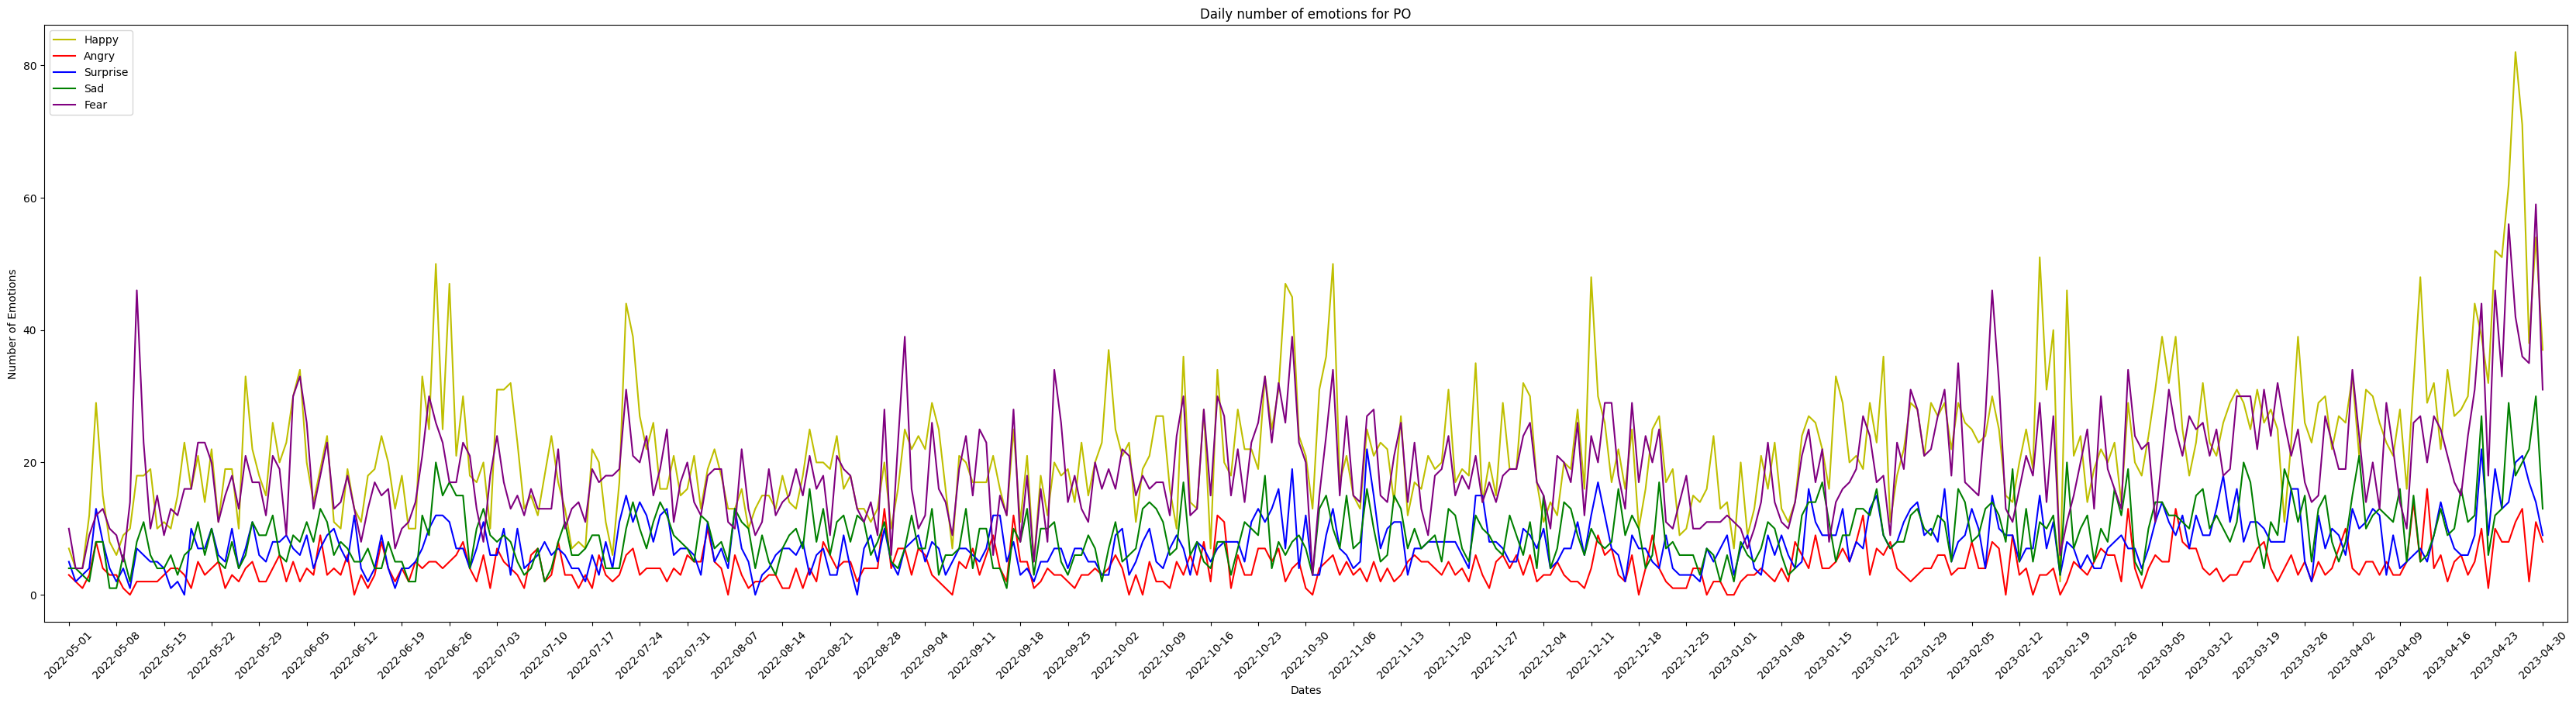

In [145]:
fig, ax = plt.subplots(figsize=(42, 10))
ax.plot(po_emotions.formatted_date, po_emotions["happy"], c='y', label='Happy')
ax.plot(po_emotions.formatted_date, po_emotions["angry"], c='r', label='Angry')
ax.plot(po_emotions.formatted_date, po_emotions["surprise"], c='b', label='Surprise')
ax.plot(po_emotions.formatted_date, po_emotions["sad"], c='g', label='Sad')
ax.plot(po_emotions.formatted_date, po_emotions["fear"], c='purple', label='Fear')

ax.set_xlabel('Dates')
ax.set_ylabel('Number of Emotions')
ax.set_title('Daily number of emotions for PO')
plt.xticks(po_emotions.formatted_date[::7], rotation=45)
ax.margins(x=0.01)
plt.legend();

plt.show();

When it comes to PO we can see that the dominant emotions are happiness and fear.
The least occurring emotion is anger.

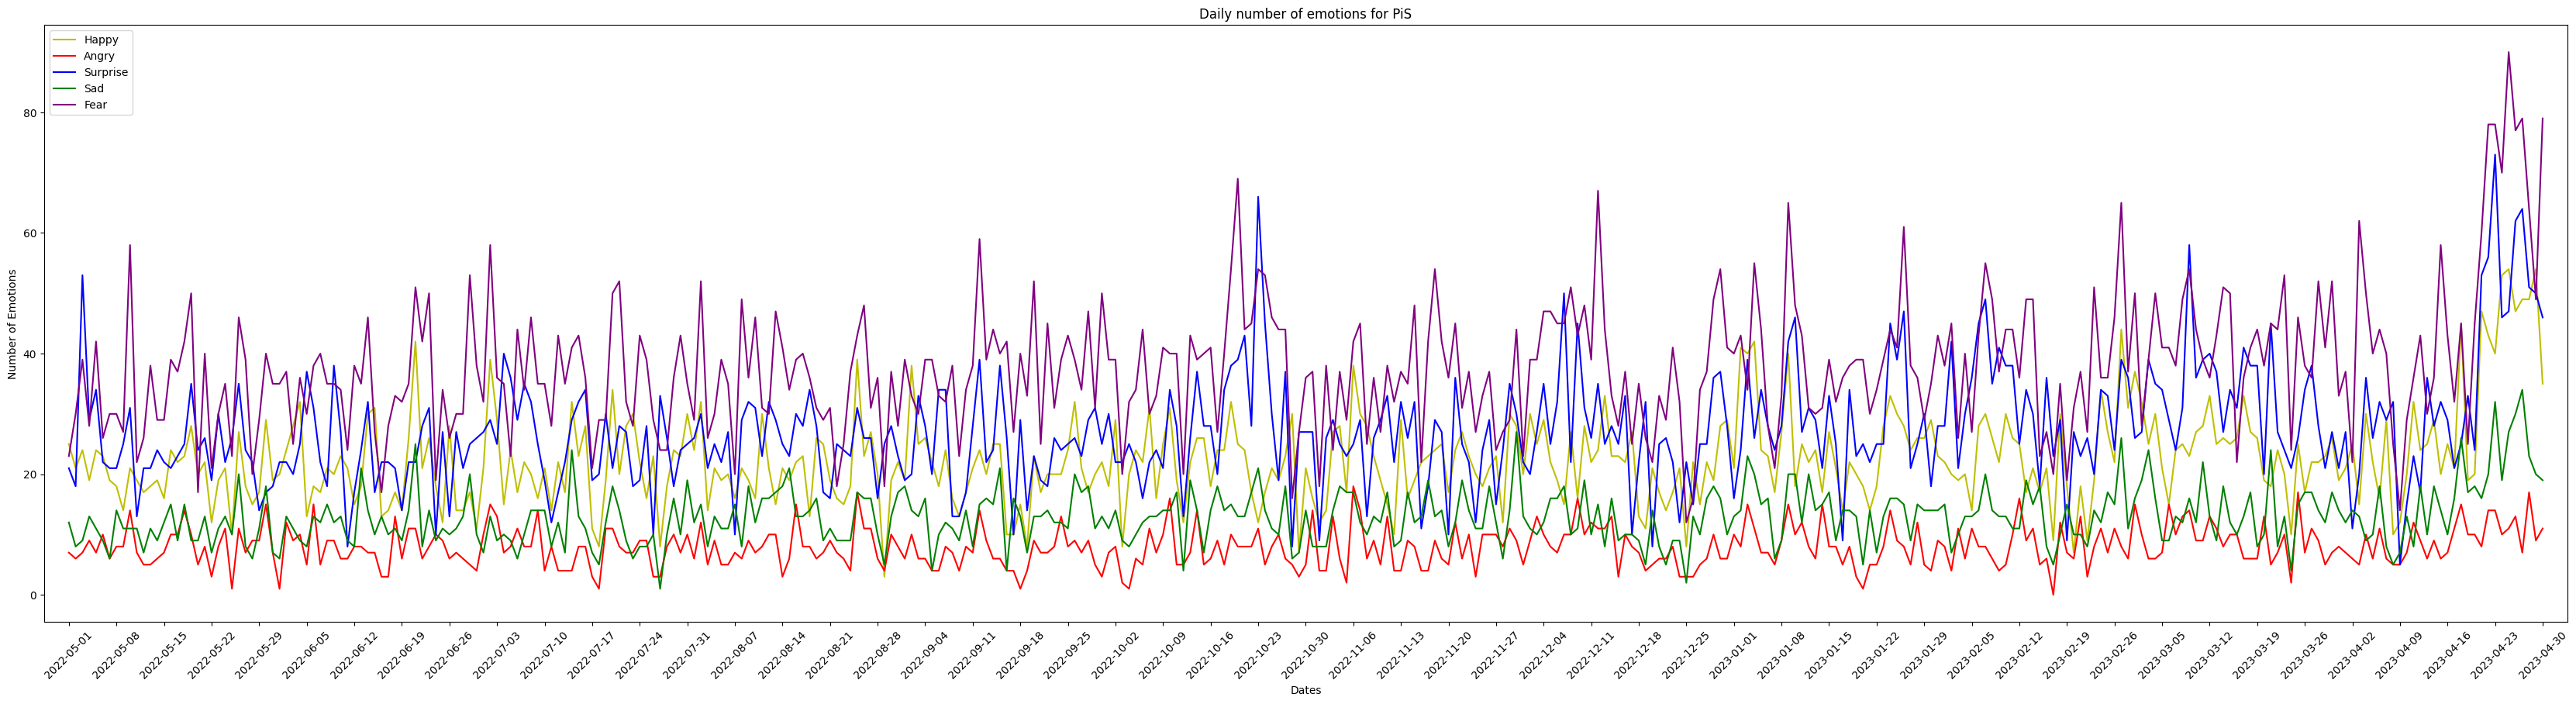

In [146]:
fig, ax = plt.subplots(figsize=(42, 10))
ax.plot(pis_emotions.formatted_date, pis_emotions["happy"], c='y', label='Happy')
ax.plot(pis_emotions.formatted_date, pis_emotions["angry"], c='r', label='Angry')
ax.plot(pis_emotions.formatted_date, pis_emotions["surprise"], c='b', label='Surprise')
ax.plot(pis_emotions.formatted_date, pis_emotions["sad"], c='g', label='Sad')
ax.plot(pis_emotions.formatted_date, pis_emotions["fear"], c='purple', label='Fear')

ax.set_xlabel('Dates')
ax.set_ylabel('Number of Emotions')
ax.set_title('Daily number of emotions for PiS')
plt.xticks(pis_emotions.formatted_date[::7], rotation=45)
ax.margins(x=0.01)
plt.legend();

plt.show();

When it comes to PiS, the dominant emotions are fear and surprise and same as PO, the anger comes at the last place.

# Summary

To sum up the project we can imply that overall sentiment for PiS through the past year was more positive than the sentiment for PO (the best visual representation of this can be seen on weekly sentiment plots).

However when it comes to emotions, PO had overall better ratio of positive emotions to negative emotions through the past year. We can see that the dominant emotion for PO was happiness and for PiS it was fear.

## Bibliography
* https://medium.com/geekculture/how-to-label-unlabeled-tweets-fb701b97ebf
* https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483